# Problem3

In [1]:
import os
import random
import math
import copy
import torch
import numpy as np
import torch.optim as optim
import torchvision.datasets as DS
import torch.utils.data as data
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split

# If a GPU is available, use it
# Pytorch uses an elegant way to keep the code device agnostic
if torch.cuda.is_available():
    device = torch.device("cuda")
    use_cuda = True
else:
    device = torch.device("cpu")
    use_cuda = False
    
print(device)


# If in clolab environment or not
isColab = False


cuda


### Loading data

In [2]:
if not isColab:
    trainImageFolder = "./trainset/"
    testImageFolder = "./testset/"
else:
    # code here to fetch and load colab folders.
    noop()
    
BATCH_SIZE=512 

# Data augmentation is done through the Randomization of the transforms applied each time an image is loaded in the epoche.
# Each epoche will have different subset of transformations done on the images.
Transform_img = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine((10,10), translate=(0.1,0.1)),
    transforms.ToTensor()
])
tensor_img_transform = transforms.Compose([transforms.ToTensor()])

# Load from image folder directly, and assign the data augmentaion through the transform
full_dataset = DS.ImageFolder(root=trainImageFolder, transform=Transform_img)

# Seperate the training and validation set: 80% training, 20% validation
train_size = int(0.8 * len(full_dataset))
valid_size = len(full_dataset) - train_size
train_data, valid_data = torch.utils.data.random_split(full_dataset, [train_size, valid_size])

train_loader = data.DataLoader(
    train_data, 
    batch_size=BATCH_SIZE, 
    shuffle=True,  
    num_workers=4,
    pin_memory=use_cuda
)

valid_loader = data.DataLoader(
    valid_data, 
    batch_size=BATCH_SIZE, 
    shuffle=True,  
    num_workers=4,
    pin_memory=use_cuda
)

indices = list(range(len(train_data)))
random.shuffle(indices)
scratch_loader = data.DataLoader(
    train_data, 
    batch_size=BATCH_SIZE, 
    sampler=SubsetRandomSampler(indices[:64]),
    num_workers=1,
    pin_memory=use_cuda
)

### Validate format

This is the shape of one batch of inputs torch.Size([512, 3, 64, 64])
This is the shape of one batch of targets torch.Size([512])
This is an image of class tensor(0)
(3, 64, 64)


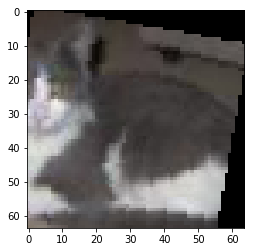

In [3]:
for step, (x, y) in enumerate(valid_loader):
    
    print(f"This is the shape of one batch of inputs {x.shape}")
    print(f"This is the shape of one batch of targets {y.shape}")
    print("This is an image of class", y[0])

    print(x[step].numpy().shape)
    img = np.transpose(x[step].numpy(), (1, 2, 0)) # We actually want the chanels in the last column
    plt.imshow(img)
    break

### Model definitions
Heavely inspired from https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/ (MIT Liscence)
The BasicBlock is extracted from the repositery, but it's the building block for a resnet with bypass connections. The normalisations were removed since we were not allowed to use them whithout coding them ourselfs. 

In [3]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        #self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        #self.bn2 = nn.BatchNorm2d(planes)
        self.stride = stride
        
        self.downsample = None
        if inplanes != planes:
            self.downsample = nn.Sequential(
                conv1x1(inplanes, planes, stride),
                # nn.BatchNorm2d(planes),
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        # out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        # out = self.bn2(out)
        
        # Reduce the sample size so the residual matches size
        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [4]:
class BasicNet(nn.Module):
    """Affordable convolutions for the people."""
    def initialize(self):
        nn.init.xavier_uniform_(self.fc.weight.data)
        self.fc.bias.data.zero_()
        #nn.init.xavier_uniform_(self.fc2.weight.data)
        #self.fc2.bias.data.zero_()
        
    def __init__(self):
        super().__init__()
        self.conv1 = conv3x3(3, 64, 2)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        #self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=3, padding=1)
        
        self.layer1 = BasicBlock(64, 64)
        self.layer2= BasicBlock(64, 128, 2)
        self.layer3= BasicBlock(128, 128)
        self.layer4= BasicBlock(128, 256, 2)
        self.layer5= BasicBlock(256, 256)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc = nn.Linear(256, 1)
        # self.sm = nn.Sigmoid() # Because we are doing classification. We could use Sigmoid since this is a binary classification, 
        self.initialize()

    def forward(self, xin):
        x = self.conv1(xin)
       # x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer1(x)
        
        x = self.layer2(x)
        
        x = self.layer3(x)
        x = self.layer3(x)
        x = self.layer3(x)
        
        x = self.layer4(x)
        
        x = self.layer5(x)
        x = self.layer5(x)
        x = self.layer5(x)
        x = self.layer5(x)
        x = self.layer5(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1) # flatten
        #x = self.fc1(x)
        #x = self.relu(x)
        x = self.fc(x)
        #x = self.sm(x)
        
        return x
    

In [9]:
class BasicNet_secondIteration(nn.Module):
    def initialize(self):
        nn.init.xavier_uniform_(self.fc.weight.data)
        self.fc.bias.data.zero_()
        
    def __init__(self):
        super().__init__()
        self.conv1 = conv3x3(3, 64, 2)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1_0 = BasicBlock(64, 64)
        self.layer1_1 = BasicBlock(64, 64)
        
        self.layer2_up= BasicBlock(64, 128, 2)
        
        self.layer3_0= BasicBlock(128, 128)
        self.layer3_1= BasicBlock(128, 128)
        self.layer3_2= BasicBlock(128, 128)
        
        self.layer4_up= BasicBlock(128, 256, 2)
        
        self.layer5_0= BasicBlock(256, 256)
        self.layer5_1= BasicBlock(256, 256)
        self.layer5_2= BasicBlock(256, 256)
        self.layer5_3= BasicBlock(256, 256)
        self.layer5_4= BasicBlock(256, 256)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc = nn.Linear(256, 1)
        self.initialize()

    def forward(self, xin):
        x = self.conv1(xin)
       # x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1_0(x)
        x = self.layer1_1(x)
        
        x = self.layer2_up(x)
        
        x = self.layer3_0(x)
        x = self.layer3_1(x)
        x = self.layer3_2(x)
        
        x = self.layer4_up(x)
        
        x = self.layer5_0(x)
        x = self.layer5_1(x)
        x = self.layer5_2(x)
        x = self.layer5_3(x)
        x = self.layer5_4(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1) # flatten
        x = self.fc(x)
        
        return x

### Training

In [7]:
# Surrogate loss used for training
# If we were to use Softmax as our activation in our model, we should actually use Binary Cross Entropy Loss
# nn.BCELoss()
loss_fn = nn.BCEWithLogitsLoss() 
test_loss_fn = nn.BCEWithLogitsLoss(reduction='sum')

# spot to save your learning curves, and potentially checkpoint your models
savedir = 'results'
if not os.path.exists(savedir):
    os.makedirs(savedir)

## This method comes from the lab session number 11 of the class
def train(model, train_loader, optimizer, epoch ):
    """Perform one epoch of training."""
    model.train()
    
    for batch_idx, (inputs, target) in enumerate(train_loader):
        inputs, target = inputs.to(device), target.to(device) # Send data to the device
        target = target.view(-1,1).float()
        
        optimizer.zero_grad()
        output = model.forward(inputs)
        #print(output)
        #print(target.float())
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(inputs), len(train_loader) *len(inputs) ,
                100. * batch_idx / len(train_loader), loss.item()))

In [8]:
## This method comes from the lab session number 11 of the class
sigmoid_ = nn.Sigmoid()
def test(model, test_loader):
    """Evaluate the model by doing one pass over a dataset"""
    model.eval()
    
    test_loss = 0
    correct = 0
    test_size = 0
    
    with torch.no_grad(): # save some computations
      
        for inputs, target in test_loader:
            inputs, target = inputs.to(device), target.to(device)
            target = target.view(-1,1).float()
            test_size += target.size(0)
            
            output = model(inputs)
            loss = test_loss_fn(output, target)
            test_loss += loss
            
            ## VERY IMPORTANT: when using BCEWithLogitsLoss, we have to pass the output in a Sigmoid since it was part of 
            ## BCEWithLogitsLoss when we did the backprop!
            pred = sigmoid_(output).round()
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= test_size
    accuracy = correct / test_size
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, test_size,
        100. * accuracy))
    
    return test_loss, accuracy

### Overfitting capacity 
We want to validate we have the capacity to at least overfit a small number of examples to make sure our model is at least learning something. This also helps to determin the step size we should use for the longer learning cycles. 

In [10]:
overfit_model = BasicNet().to(device)

lr = 0.06
optimizer = optim.SGD(overfit_model.parameters(), lr=lr)

#results = {'name':'basic', 'lr': lr, 'loss': [], 'accuracy':[]}
#savefile = os.path.join(savedir, results['name']+str(results['lr'])+'.pkl' )

for epoch in range(1, 2):
    train(overfit_model, scratch_loader, optimizer, epoch)
    loss, acc = test(overfit_model, scratch_loader)


Train Epoch: 1 [0/64 (0%)]	Loss: 0.689191
Test set: Average loss: 0.6873, Accuracy: 35/64 (55%)



In [16]:
model = BasicNet().to(device)

# 0.001 never learned
# 0.1 too mutch?
lr =  0.08
optimizer = optim.SGD(model.parameters(), lr=lr)

#results = {'name':'basic', 'lr': lr, 'loss': [], 'accuracy':[]}
#savefile = os.path.join(savedir, results['name']+str(results['lr'])+'.pkl' )
best_model = None
best_acc = 0
train_losses = []
valid_losses = []
train_losses_acc = []
valid_losses_acc = []
for epoch in range(1, 200):
    train(model, train_loader, optimizer, epoch)
    tr_loss, tr_acc = test(model, train_loader)
    loss, acc = test(model, valid_loader) 
    
    train_losses.append(tr_loss)
    train_losses_acc.append(tr_acc)
    
    valid_losses.append(loss)
    valid_losses_acc.append(acc)
    
    if (acc > best_acc):
        print("Best acc: ",acc)
        best_model = copy.deepcopy(model)
        best_acc = acc

Train Epoch: 1 [0/16384 (0%)]	Loss: 0.701765
Train Epoch: 1 [5120/16384 (31%)]	Loss: 0.692914
Train Epoch: 1 [10240/16384 (62%)]	Loss: 0.692667
Train Epoch: 1 [15360/16384 (94%)]	Loss: 0.691910
Test set: Average loss: 0.6942, Accuracy: 8000/15998 (50%)

Test set: Average loss: 0.6941, Accuracy: 1999/4000 (50%)

Best acc:  0.49975
Train Epoch: 2 [0/16384 (0%)]	Loss: 0.690213
Train Epoch: 2 [5120/16384 (31%)]	Loss: 0.692550
Train Epoch: 2 [10240/16384 (62%)]	Loss: 0.689801
Train Epoch: 2 [15360/16384 (94%)]	Loss: 0.691252
Test set: Average loss: 0.6910, Accuracy: 8770/15998 (55%)

Test set: Average loss: 0.6908, Accuracy: 2189/4000 (55%)

Best acc:  0.54725
Train Epoch: 3 [0/16384 (0%)]	Loss: 0.691126
Train Epoch: 3 [5120/16384 (31%)]	Loss: 0.690888
Train Epoch: 3 [10240/16384 (62%)]	Loss: 0.689404
Train Epoch: 3 [15360/16384 (94%)]	Loss: 0.688847
Test set: Average loss: 0.6902, Accuracy: 8072/15998 (50%)

Test set: Average loss: 0.6900, Accuracy: 2002/4000 (50%)

Train Epoch: 4 [0/16384

Train Epoch: 26 [15360/16384 (94%)]	Loss: 0.695543
Test set: Average loss: 0.6406, Accuracy: 10270/15998 (64%)

Test set: Average loss: 0.6401, Accuracy: 2539/4000 (63%)

Train Epoch: 27 [0/16384 (0%)]	Loss: 0.631793
Train Epoch: 27 [5120/16384 (31%)]	Loss: 0.679991
Train Epoch: 27 [10240/16384 (62%)]	Loss: 0.669745
Train Epoch: 27 [15360/16384 (94%)]	Loss: 0.630631
Test set: Average loss: 0.6511, Accuracy: 9945/15998 (62%)

Test set: Average loss: 0.6545, Accuracy: 2470/4000 (62%)

Train Epoch: 28 [0/16384 (0%)]	Loss: 0.657326
Train Epoch: 28 [5120/16384 (31%)]	Loss: 0.616569
Train Epoch: 28 [10240/16384 (62%)]	Loss: 0.658541
Train Epoch: 28 [15360/16384 (94%)]	Loss: 0.632280
Test set: Average loss: 0.6380, Accuracy: 10180/15998 (64%)

Test set: Average loss: 0.6377, Accuracy: 2545/4000 (64%)

Train Epoch: 29 [0/16384 (0%)]	Loss: 0.634529
Train Epoch: 29 [5120/16384 (31%)]	Loss: 0.642863
Train Epoch: 29 [10240/16384 (62%)]	Loss: 0.648269
Train Epoch: 29 [15360/16384 (94%)]	Loss: 0.626

Train Epoch: 52 [0/16384 (0%)]	Loss: 0.590212
Train Epoch: 52 [5120/16384 (31%)]	Loss: 0.606271
Train Epoch: 52 [10240/16384 (62%)]	Loss: 0.651965
Train Epoch: 52 [15360/16384 (94%)]	Loss: 0.588592
Test set: Average loss: 0.6006, Accuracy: 10664/15998 (67%)

Test set: Average loss: 0.6008, Accuracy: 2669/4000 (67%)

Train Epoch: 53 [0/16384 (0%)]	Loss: 0.581678
Train Epoch: 53 [5120/16384 (31%)]	Loss: 0.601355
Train Epoch: 53 [10240/16384 (62%)]	Loss: 0.564114
Train Epoch: 53 [15360/16384 (94%)]	Loss: 0.583108
Test set: Average loss: 0.5875, Accuracy: 10909/15998 (68%)

Test set: Average loss: 0.5815, Accuracy: 2756/4000 (69%)

Train Epoch: 54 [0/16384 (0%)]	Loss: 0.573747
Train Epoch: 54 [5120/16384 (31%)]	Loss: 0.599249
Train Epoch: 54 [10240/16384 (62%)]	Loss: 0.520066
Train Epoch: 54 [15360/16384 (94%)]	Loss: 0.578680
Test set: Average loss: 0.5772, Accuracy: 11174/15998 (70%)

Test set: Average loss: 0.5859, Accuracy: 2806/4000 (70%)

Train Epoch: 55 [0/16384 (0%)]	Loss: 0.571142


Train Epoch: 77 [15360/16384 (94%)]	Loss: 0.497441
Test set: Average loss: 0.5612, Accuracy: 11440/15998 (72%)

Test set: Average loss: 0.5788, Accuracy: 2867/4000 (72%)

Train Epoch: 78 [0/16384 (0%)]	Loss: 0.601000
Train Epoch: 78 [5120/16384 (31%)]	Loss: 0.487851
Train Epoch: 78 [10240/16384 (62%)]	Loss: 0.560485
Train Epoch: 78 [15360/16384 (94%)]	Loss: 0.582966
Test set: Average loss: 0.5052, Accuracy: 12293/15998 (77%)

Test set: Average loss: 0.5166, Accuracy: 3008/4000 (75%)

Train Epoch: 79 [0/16384 (0%)]	Loss: 0.501722
Train Epoch: 79 [5120/16384 (31%)]	Loss: 0.502761
Train Epoch: 79 [10240/16384 (62%)]	Loss: 0.487640
Train Epoch: 79 [15360/16384 (94%)]	Loss: 0.490075
Test set: Average loss: 0.5134, Accuracy: 12122/15998 (76%)

Test set: Average loss: 0.5251, Accuracy: 3002/4000 (75%)

Train Epoch: 80 [0/16384 (0%)]	Loss: 0.514499
Train Epoch: 80 [5120/16384 (31%)]	Loss: 0.574936
Train Epoch: 80 [10240/16384 (62%)]	Loss: 0.591002
Train Epoch: 80 [15360/16384 (94%)]	Loss: 0.60


Train Epoch: 103 [0/16384 (0%)]	Loss: 0.445046
Train Epoch: 103 [5120/16384 (31%)]	Loss: 0.387401
Train Epoch: 103 [10240/16384 (62%)]	Loss: 0.402569
Train Epoch: 103 [15360/16384 (94%)]	Loss: 0.384336
Test set: Average loss: 0.4652, Accuracy: 12437/15998 (78%)

Test set: Average loss: 0.4945, Accuracy: 3039/4000 (76%)

Train Epoch: 104 [0/16384 (0%)]	Loss: 0.448650
Train Epoch: 104 [5120/16384 (31%)]	Loss: 0.388282
Train Epoch: 104 [10240/16384 (62%)]	Loss: 0.352594
Train Epoch: 104 [15360/16384 (94%)]	Loss: 0.410994
Test set: Average loss: 0.4050, Accuracy: 13049/15998 (82%)

Test set: Average loss: 0.4401, Accuracy: 3217/4000 (80%)

Train Epoch: 105 [0/16384 (0%)]	Loss: 0.375234
Train Epoch: 105 [5120/16384 (31%)]	Loss: 0.364230
Train Epoch: 105 [10240/16384 (62%)]	Loss: 0.343870
Train Epoch: 105 [15360/16384 (94%)]	Loss: 0.413614
Test set: Average loss: 0.5070, Accuracy: 12081/15998 (76%)

Test set: Average loss: 0.5395, Accuracy: 2961/4000 (74%)

Train Epoch: 106 [0/16384 (0%)]	L

Train Epoch: 128 [0/16384 (0%)]	Loss: 0.320818
Train Epoch: 128 [5120/16384 (31%)]	Loss: 0.336223
Train Epoch: 128 [10240/16384 (62%)]	Loss: 0.274478
Train Epoch: 128 [15360/16384 (94%)]	Loss: 0.329331
Test set: Average loss: 0.4341, Accuracy: 12849/15998 (80%)

Test set: Average loss: 0.4879, Accuracy: 3151/4000 (79%)

Train Epoch: 129 [0/16384 (0%)]	Loss: 0.464560
Train Epoch: 129 [5120/16384 (31%)]	Loss: 0.367380
Train Epoch: 129 [10240/16384 (62%)]	Loss: 0.327209
Train Epoch: 129 [15360/16384 (94%)]	Loss: 0.265382
Test set: Average loss: 0.3459, Accuracy: 13592/15998 (85%)

Test set: Average loss: 0.4044, Accuracy: 3273/4000 (82%)

Train Epoch: 130 [0/16384 (0%)]	Loss: 0.397089
Train Epoch: 130 [5120/16384 (31%)]	Loss: 0.335060
Train Epoch: 130 [10240/16384 (62%)]	Loss: 0.295262
Train Epoch: 130 [15360/16384 (94%)]	Loss: 0.323435
Test set: Average loss: 0.5185, Accuracy: 11855/15998 (74%)

Test set: Average loss: 0.5421, Accuracy: 2881/4000 (72%)

Train Epoch: 131 [0/16384 (0%)]	Lo

Train Epoch: 153 [5120/16384 (31%)]	Loss: 0.240014
Train Epoch: 153 [10240/16384 (62%)]	Loss: 0.255663
Train Epoch: 153 [15360/16384 (94%)]	Loss: 0.256844
Test set: Average loss: 0.3642, Accuracy: 13503/15998 (84%)

Test set: Average loss: 0.4188, Accuracy: 3258/4000 (81%)

Train Epoch: 154 [0/16384 (0%)]	Loss: 0.378533
Train Epoch: 154 [5120/16384 (31%)]	Loss: 0.260384
Train Epoch: 154 [10240/16384 (62%)]	Loss: 0.238369
Train Epoch: 154 [15360/16384 (94%)]	Loss: 0.253805
Test set: Average loss: 0.3368, Accuracy: 13584/15998 (85%)

Test set: Average loss: 0.4063, Accuracy: 3254/4000 (81%)

Train Epoch: 155 [0/16384 (0%)]	Loss: 0.337594
Train Epoch: 155 [5120/16384 (31%)]	Loss: 0.269504
Train Epoch: 155 [10240/16384 (62%)]	Loss: 0.290644
Train Epoch: 155 [15360/16384 (94%)]	Loss: 0.193473
Test set: Average loss: 0.3111, Accuracy: 13850/15998 (87%)

Test set: Average loss: 0.4114, Accuracy: 3327/4000 (83%)

Train Epoch: 156 [0/16384 (0%)]	Loss: 0.331494
Train Epoch: 156 [5120/16384 (31%)

Train Epoch: 178 [15360/16384 (94%)]	Loss: 0.232220
Test set: Average loss: 0.3017, Accuracy: 13905/15998 (87%)

Test set: Average loss: 0.4253, Accuracy: 3307/4000 (83%)

Train Epoch: 179 [0/16384 (0%)]	Loss: 0.290603
Train Epoch: 179 [5120/16384 (31%)]	Loss: 0.185467
Train Epoch: 179 [10240/16384 (62%)]	Loss: 0.288383
Train Epoch: 179 [15360/16384 (94%)]	Loss: 0.133494
Test set: Average loss: 0.4695, Accuracy: 13207/15998 (83%)

Test set: Average loss: 0.5830, Accuracy: 3189/4000 (80%)

Train Epoch: 180 [0/16384 (0%)]	Loss: 0.502067
Train Epoch: 180 [5120/16384 (31%)]	Loss: 0.298088
Train Epoch: 180 [10240/16384 (62%)]	Loss: 0.239815
Train Epoch: 180 [15360/16384 (94%)]	Loss: 0.253492
Test set: Average loss: 0.3570, Accuracy: 13337/15998 (83%)

Test set: Average loss: 0.4526, Accuracy: 3176/4000 (79%)

Train Epoch: 181 [0/16384 (0%)]	Loss: 0.394105
Train Epoch: 181 [5120/16384 (31%)]	Loss: 0.320885
Train Epoch: 181 [10240/16384 (62%)]	Loss: 0.203663
Train Epoch: 181 [15360/16384 (94%

### more training...

In [19]:
lr = 0.0005
optimizer = optim.SGD(model.parameters(), lr=lr)

more_train_losses = []
more_valid_losses = []
for epoch in range(1, 30):
    train(model, train_loader, optimizer, epoch)
    tr_loss, tr_acc = test(model, train_loader)
    loss, acc = test(model, valid_loader) 
    
    more_train_losses.append(tr_loss)
    more_valid_losses.append(loss)
    
    if (acc > best_acc):
        print("Best acc: ",acc)
        best_model = copy.deepcopy(model)
        best_acc = acc

Train Epoch: 1 [0/16384 (0%)]	Loss: 0.031841
Train Epoch: 1 [5120/16384 (31%)]	Loss: 0.073640
Train Epoch: 1 [10240/16384 (62%)]	Loss: 0.033798
Train Epoch: 1 [15360/16384 (94%)]	Loss: 0.049215
Test set: Average loss: 0.0333, Accuracy: 15798/15998 (99%)

Test set: Average loss: 0.5582, Accuracy: 3529/4000 (88%)

Train Epoch: 2 [0/16384 (0%)]	Loss: 0.040717
Train Epoch: 2 [5120/16384 (31%)]	Loss: 0.057396
Train Epoch: 2 [10240/16384 (62%)]	Loss: 0.026375
Train Epoch: 2 [15360/16384 (94%)]	Loss: 0.019762
Test set: Average loss: 0.0377, Accuracy: 15763/15998 (99%)

Test set: Average loss: 0.5504, Accuracy: 3530/4000 (88%)

Train Epoch: 3 [0/16384 (0%)]	Loss: 0.029647
Train Epoch: 3 [5120/16384 (31%)]	Loss: 0.040281
Train Epoch: 3 [10240/16384 (62%)]	Loss: 0.039540
Train Epoch: 3 [15360/16384 (94%)]	Loss: 0.033525
Test set: Average loss: 0.0379, Accuracy: 15761/15998 (99%)

Test set: Average loss: 0.5559, Accuracy: 3516/4000 (88%)

Train Epoch: 4 [0/16384 (0%)]	Loss: 0.035403
Train Epoch: 


Train Epoch: 27 [0/16384 (0%)]	Loss: 0.027341
Train Epoch: 27 [5120/16384 (31%)]	Loss: 0.042077
Train Epoch: 27 [10240/16384 (62%)]	Loss: 0.032524
Train Epoch: 27 [15360/16384 (94%)]	Loss: 0.030273
Test set: Average loss: 0.0322, Accuracy: 15796/15998 (99%)

Test set: Average loss: 0.6062, Accuracy: 3515/4000 (88%)

Train Epoch: 28 [0/16384 (0%)]	Loss: 0.019633
Train Epoch: 28 [5120/16384 (31%)]	Loss: 0.021080
Train Epoch: 28 [10240/16384 (62%)]	Loss: 0.043452
Train Epoch: 28 [15360/16384 (94%)]	Loss: 0.048397
Test set: Average loss: 0.0317, Accuracy: 15794/15998 (99%)

Test set: Average loss: 0.6188, Accuracy: 3504/4000 (88%)

Train Epoch: 29 [0/16384 (0%)]	Loss: 0.024534
Train Epoch: 29 [5120/16384 (31%)]	Loss: 0.043656
Train Epoch: 29 [10240/16384 (62%)]	Loss: 0.022411
Train Epoch: 29 [15360/16384 (94%)]	Loss: 0.025659
Test set: Average loss: 0.0332, Accuracy: 15797/15998 (99%)

Test set: Average loss: 0.6105, Accuracy: 3504/4000 (88%)



In [18]:
print(best_acc)

0.86225


### Learning graphs

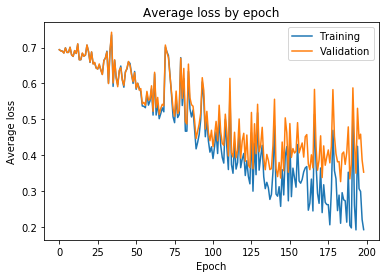

In [17]:
plt.plot(np.arange(0,len(train_losses),1), train_losses, label="Training")
plt.plot(np.arange(0,len(valid_losses),1), valid_losses, label="Validation")
plt.title("Average loss by epoch")
plt.xlabel("Epoch")
plt.ylabel("Average loss")
plt.legend()
plt.show()

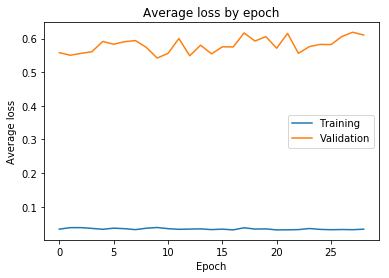

In [20]:
plt.plot(np.arange(0,len(more_train_losses),1), more_train_losses, label="Training")
plt.plot(np.arange(0,len(more_valid_losses),1), more_valid_losses, label="Validation")
plt.title("Average loss by epoch")
plt.xlabel("Epoch")
plt.ylabel("Average loss")
plt.legend()
plt.show()

## Second Model Type Training
By outputting the model structure and the number of parameters, I realzed it had less parameters then what I was expecting. So here is a second model training.

In [11]:
model_2 = BasicNet_secondIteration().to(device)

lr =  0.08
optimizer = optim.SGD(model_2.parameters(), lr=lr)

best_model_2 = None
best_acc_2 = 0
train_losses_2 = []
valid_losses_2 = []
for epoch in range(1, 100):
    train(model_2, train_loader, optimizer, epoch)
    tr_loss_2, tr_acc_2 = test(model_2, train_loader)
    loss_2, acc_2 = test(model_2, valid_loader) 
    
    train_losses_2.append(tr_loss_2)
    valid_losses_2.append(loss_2)
    if (acc_2 > best_acc_2):
        print("Best acc: ",acc_2)
        best_model_2 = copy.deepcopy(model_2)
        best_acc_2 = acc_2

Train Epoch: 1 [0/16384 (0%)]	Loss: 0.691550
Train Epoch: 1 [5120/16384 (31%)]	Loss: 0.693288
Train Epoch: 1 [10240/16384 (62%)]	Loss: 0.692799
Train Epoch: 1 [15360/16384 (94%)]	Loss: 0.691044
Test set: Average loss: 0.6926, Accuracy: 8039/15998 (50%)

Test set: Average loss: 0.6932, Accuracy: 1964/4000 (49%)

Best acc:  0.491
Train Epoch: 2 [0/16384 (0%)]	Loss: 0.692555
Train Epoch: 2 [5120/16384 (31%)]	Loss: 0.691054
Train Epoch: 2 [10240/16384 (62%)]	Loss: 0.692840
Train Epoch: 2 [15360/16384 (94%)]	Loss: 0.692050
Test set: Average loss: 0.6923, Accuracy: 8064/15998 (50%)

Test set: Average loss: 0.6930, Accuracy: 1965/4000 (49%)

Best acc:  0.49125
Train Epoch: 3 [0/16384 (0%)]	Loss: 0.693610
Train Epoch: 3 [5120/16384 (31%)]	Loss: 0.691775
Train Epoch: 3 [10240/16384 (62%)]	Loss: 0.693325
Train Epoch: 3 [15360/16384 (94%)]	Loss: 0.690328
Test set: Average loss: 0.6921, Accuracy: 8063/15998 (50%)

Test set: Average loss: 0.6931, Accuracy: 1973/4000 (49%)

Best acc:  0.49325
Train 


Test set: Average loss: 0.6491, Accuracy: 2506/4000 (63%)

Train Epoch: 52 [0/16384 (0%)]	Loss: 0.613200
Train Epoch: 52 [5120/16384 (31%)]	Loss: 0.584380
Train Epoch: 52 [10240/16384 (62%)]	Loss: 0.639022
Train Epoch: 52 [15360/16384 (94%)]	Loss: 0.585652
Test set: Average loss: 0.5843, Accuracy: 11051/15998 (69%)

Test set: Average loss: 0.5996, Accuracy: 2740/4000 (68%)

Train Epoch: 53 [0/16384 (0%)]	Loss: 0.560453
Train Epoch: 53 [5120/16384 (31%)]	Loss: 0.586843
Train Epoch: 53 [10240/16384 (62%)]	Loss: 0.595635
Train Epoch: 53 [15360/16384 (94%)]	Loss: 0.605457
Test set: Average loss: 0.7057, Accuracy: 9341/15998 (58%)

Test set: Average loss: 0.7336, Accuracy: 2272/4000 (57%)

Train Epoch: 54 [0/16384 (0%)]	Loss: 0.689821
Train Epoch: 54 [5120/16384 (31%)]	Loss: 0.601135
Train Epoch: 54 [10240/16384 (62%)]	Loss: 0.638536
Train Epoch: 54 [15360/16384 (94%)]	Loss: 0.556485
Test set: Average loss: 0.6157, Accuracy: 10666/15998 (67%)

Test set: Average loss: 0.6330, Accuracy: 2622

In [15]:
for epoch in range(1, 100):
    train(model_2, train_loader, optimizer, epoch)
    tr_loss_2, tr_acc_2 = test(model_2, train_loader)
    loss_2, acc_2 = test(model_2, valid_loader) 
    
    train_losses_2.append(tr_loss_2)
    valid_losses_2.append(loss_2)
    if (acc_2 > best_acc_2):
        print("Best acc: ",acc_2)
        best_model_2 = copy.deepcopy(model_2)
        best_acc_2 = acc_2

Train Epoch: 1 [0/16384 (0%)]	Loss: 0.244121
Train Epoch: 1 [5120/16384 (31%)]	Loss: 0.205982
Train Epoch: 1 [10240/16384 (62%)]	Loss: 0.398051
Train Epoch: 1 [15360/16384 (94%)]	Loss: 0.288147
Test set: Average loss: 0.3446, Accuracy: 13922/15998 (87%)

Test set: Average loss: 0.3921, Accuracy: 3311/4000 (83%)

Train Epoch: 2 [0/16384 (0%)]	Loss: 0.319304
Train Epoch: 2 [5120/16384 (31%)]	Loss: 0.234821
Train Epoch: 2 [10240/16384 (62%)]	Loss: 0.195093
Train Epoch: 2 [15360/16384 (94%)]	Loss: 0.461109
Test set: Average loss: 0.4663, Accuracy: 12254/15998 (77%)

Test set: Average loss: 0.5104, Accuracy: 3013/4000 (75%)

Train Epoch: 3 [0/16384 (0%)]	Loss: 0.442509
Train Epoch: 3 [5120/16384 (31%)]	Loss: 0.252074
Train Epoch: 3 [10240/16384 (62%)]	Loss: 0.247894
Train Epoch: 3 [15360/16384 (94%)]	Loss: 0.227978
Test set: Average loss: 0.2815, Accuracy: 14143/15998 (88%)

Test set: Average loss: 0.3856, Accuracy: 3412/4000 (85%)

Train Epoch: 4 [0/16384 (0%)]	Loss: 0.272165
Train Epoch: 


Train Epoch: 27 [0/16384 (0%)]	Loss: 0.223021
Train Epoch: 27 [5120/16384 (31%)]	Loss: 0.177859
Train Epoch: 27 [10240/16384 (62%)]	Loss: 0.250612
Train Epoch: 27 [15360/16384 (94%)]	Loss: 0.291890
Test set: Average loss: 0.2994, Accuracy: 13971/15998 (87%)

Test set: Average loss: 0.3718, Accuracy: 3329/4000 (83%)

Train Epoch: 28 [0/16384 (0%)]	Loss: 0.278253
Train Epoch: 28 [5120/16384 (31%)]	Loss: 0.218832
Train Epoch: 28 [10240/16384 (62%)]	Loss: 0.192205
Train Epoch: 28 [15360/16384 (94%)]	Loss: 0.161596
Test set: Average loss: 0.3231, Accuracy: 13931/15998 (87%)

Test set: Average loss: 0.4686, Accuracy: 3299/4000 (82%)

Train Epoch: 29 [0/16384 (0%)]	Loss: 0.362631
Train Epoch: 29 [5120/16384 (31%)]	Loss: 0.186323
Train Epoch: 29 [10240/16384 (62%)]	Loss: 0.337531
Train Epoch: 29 [15360/16384 (94%)]	Loss: 0.211274
Test set: Average loss: 0.2615, Accuracy: 14183/15998 (89%)

Test set: Average loss: 0.3952, Accuracy: 3329/4000 (83%)

Train Epoch: 30 [0/16384 (0%)]	Loss: 0.219205


Test set: Average loss: 0.3577, Accuracy: 3425/4000 (86%)

Train Epoch: 53 [0/16384 (0%)]	Loss: 0.222538
Train Epoch: 53 [5120/16384 (31%)]	Loss: 0.162557
Train Epoch: 53 [10240/16384 (62%)]	Loss: 0.164751
Train Epoch: 53 [15360/16384 (94%)]	Loss: 0.213274
Test set: Average loss: 0.2559, Accuracy: 14260/15998 (89%)

Test set: Average loss: 0.4100, Accuracy: 3352/4000 (84%)

Train Epoch: 54 [0/16384 (0%)]	Loss: 0.194926
Train Epoch: 54 [5120/16384 (31%)]	Loss: 0.129715
Train Epoch: 54 [10240/16384 (62%)]	Loss: 0.153447
Train Epoch: 54 [15360/16384 (94%)]	Loss: 0.156817
Test set: Average loss: 0.4144, Accuracy: 13727/15998 (86%)

Test set: Average loss: 0.6404, Accuracy: 3260/4000 (82%)

Train Epoch: 55 [0/16384 (0%)]	Loss: 0.409790
Train Epoch: 55 [5120/16384 (31%)]	Loss: 0.147816
Train Epoch: 55 [10240/16384 (62%)]	Loss: 0.188171
Train Epoch: 55 [15360/16384 (94%)]	Loss: 0.140428
Test set: Average loss: 0.1835, Accuracy: 14814/15998 (93%)

Test set: Average loss: 0.3757, Accuracy: 350

In [19]:
print(best_acc_2)
pytorch_total_params = sum(p.numel() for p in best_model_2.parameters() if p.requires_grad)
print(pytorch_total_params)

0.87525
8079297


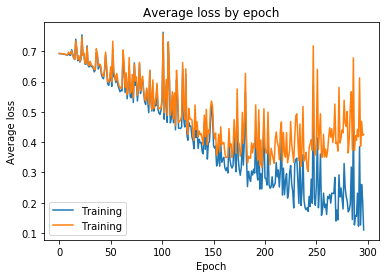

In [16]:
plt.plot(np.arange(0,len(train_losses_2),1), train_losses_2, label="Training")
plt.plot(np.arange(0,len(valid_losses_2),1), valid_losses_2, label="Training")
plt.title("Average loss by epoch")
plt.xlabel("Epoch")
plt.ylabel("Average loss")
plt.legend()
plt.show()

### Saving Model

In [19]:
import datetime
date = datetime.date.today().strftime("%B %d, %Y")
best_model.to("cpu")
torch.save(best_model, "best_model_" + date + ".pt")
torch.save(best_model.state_dict(), "best_model_dict_" + date + ".pt")
best_model.to(device)

C:\Users\Game\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type BasicNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\Game\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type BasicBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


BasicNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (layer2): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (relu): ReLU(inplace)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (downsample): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    )
  )
  (layer3): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (relu): ReLU(inplace)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1

### Optional: loading a model
Just un-comment the necessary lines

In [11]:

### Load entire model
loaded_model = torch.load("./best_model_February 09, 2019.pt")
loaded_model.eval()
loaded_model.to(device)

### Or, Load state_dict
# model = BasicNet()
# model.load_state_dict("./best_model_dict_January 30, 2019.pt")
# model.eval()
# loaded_model.to(device)


BasicNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (maxpool2): MaxPool2d(kernel_size=3, stride=3, padding=1, dilation=1, ceil_mode=False)
  (layer1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (layer2): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (relu): ReLU(inplace)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (downsample): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    )
  )
  (layer3): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [10]:
pytorch_total_params = sum(p.numel() for p in loaded_model.parameters() if p.requires_grad)
print("First model parameter count: ", pytorch_total_params)

2697153


### Generate testing output

In [14]:
testImageFolder = "./testset/"

test_official = DS.ImageFolder(root=testImageFolder, transform=tensor_img_transform)
test_loader_off = data.DataLoader(
    test_official,
    batch_size=1,
    # The sampler is an easy way to say that we're using the elements
    num_workers=1,
    pin_memory=True # Cuda
)

In [11]:
final_results = []
ouput_file = open("finalResults2.csv", "w")
# writre headers
ouput_file.write("id,label\n")
for idx, (img, label)  in enumerate(test_loader_off):
    inputs = img.to(device)

    output = best_model(inputs)

    pred = sigmoid_(output).round()
    class_name_pred = full_dataset.classes[pred.int()]
    # get the file name
    path, filename = os.path.split(test_official.imgs[idx][0]) # (img path, label), no labels for tests, so we want arg[0]
    filename, extension = filename.split(".")
    # save the results
    final_results.append([filename, class_name_pred])
    ouput_file.write(str(filename) + "," + class_name_pred + "\n")
    

ouput_file.close()

### Vusualise convolution

Weight values (128, 128, 3, 3)


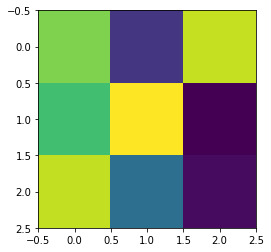

Cat


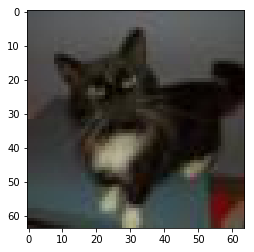

Output of convolution torch.Size([1, 64, 32, 32])


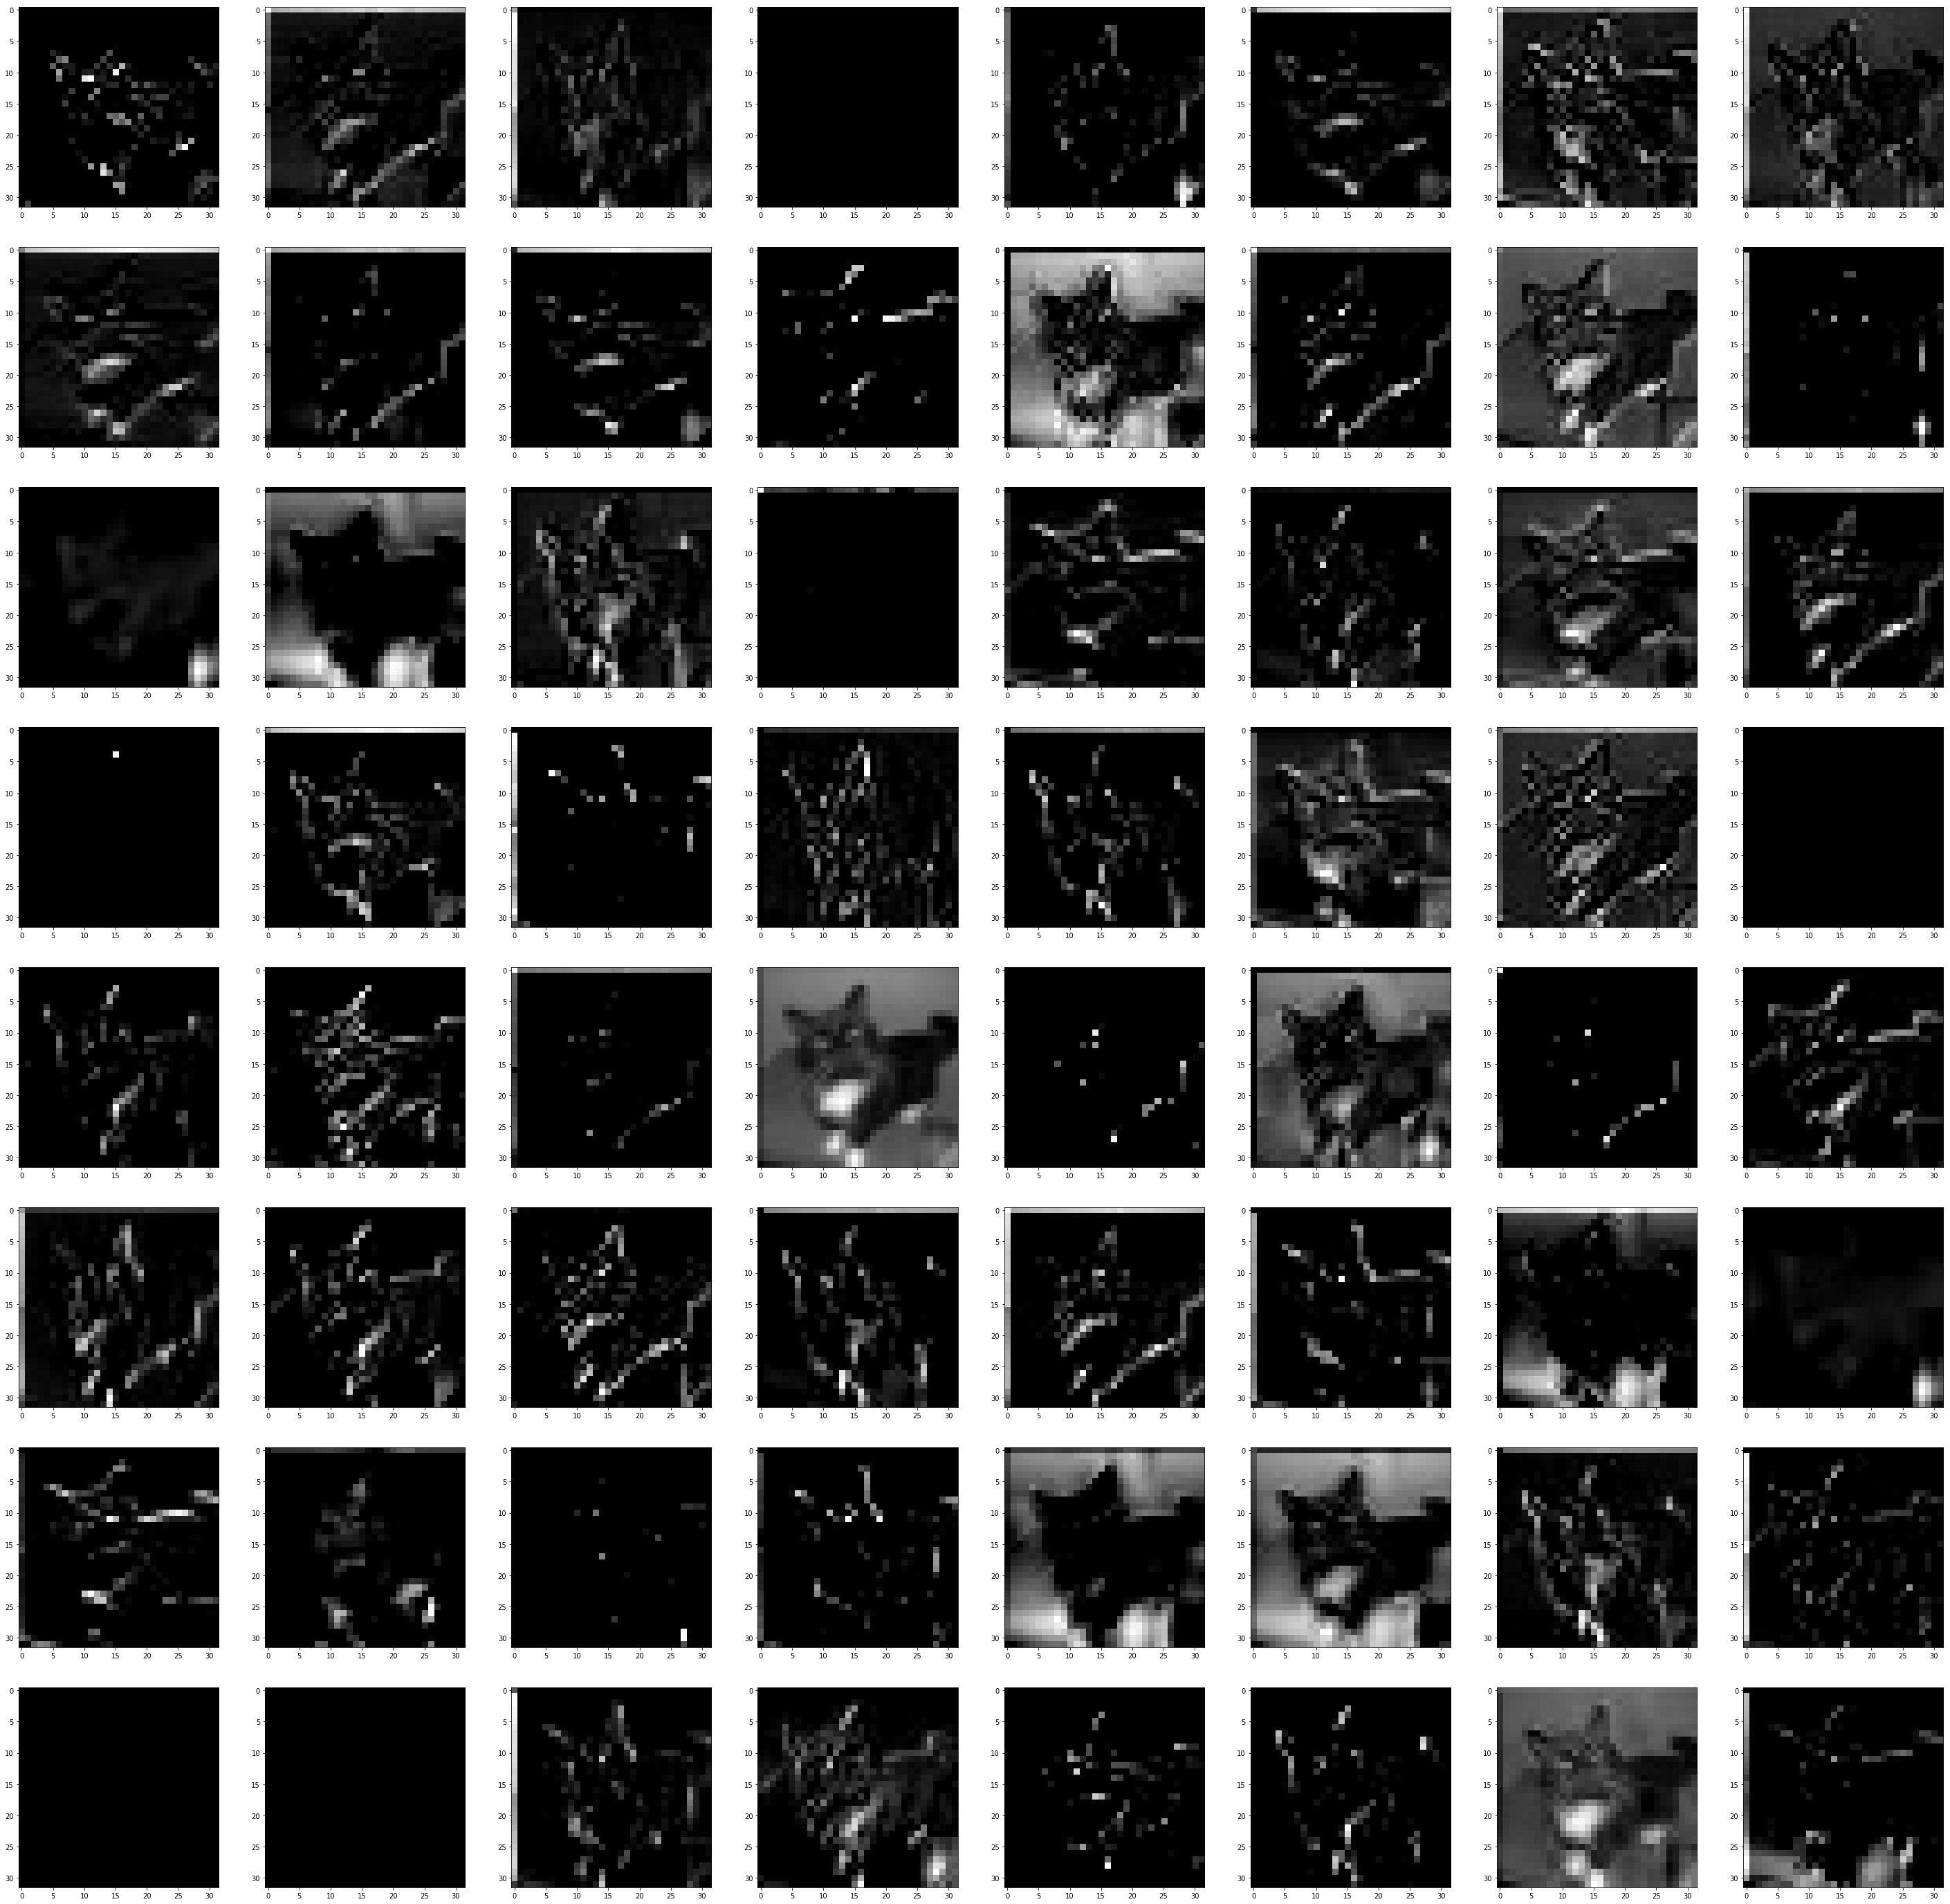

Cat


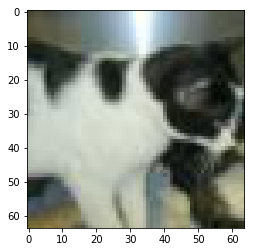

Output of convolution torch.Size([1, 64, 32, 32])


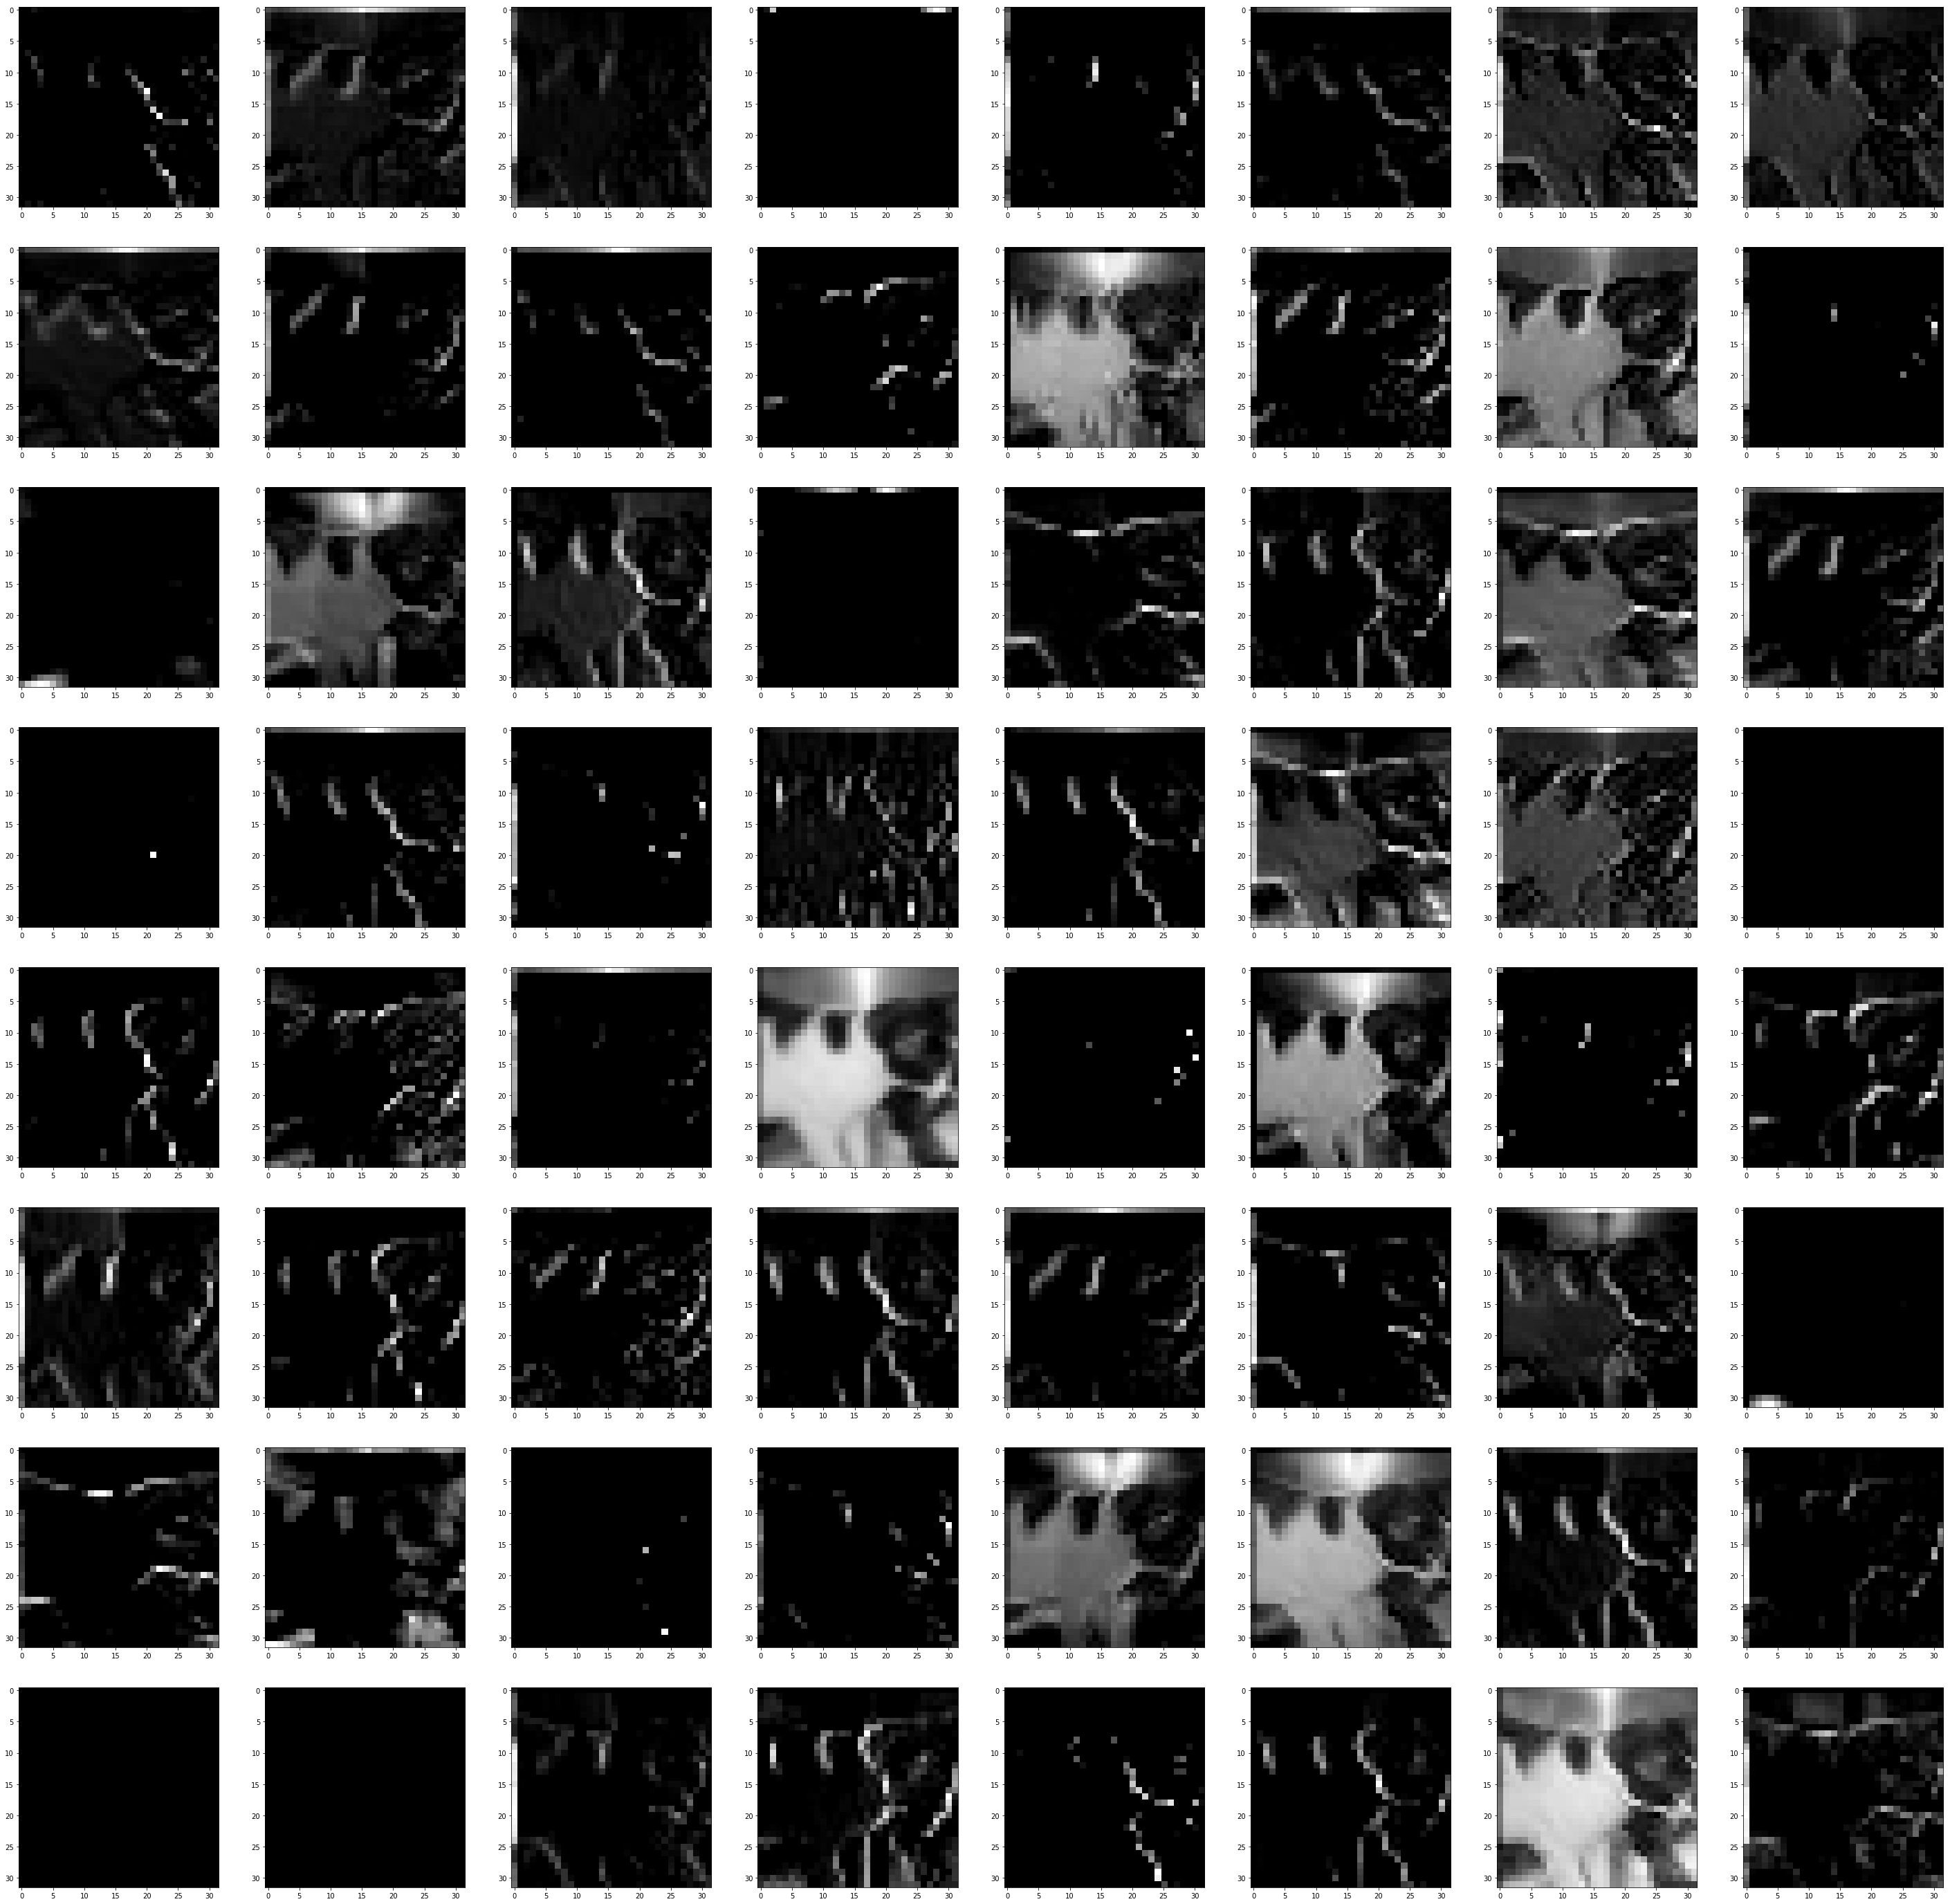

Dog


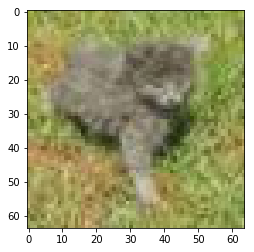

Output of convolution torch.Size([1, 64, 32, 32])


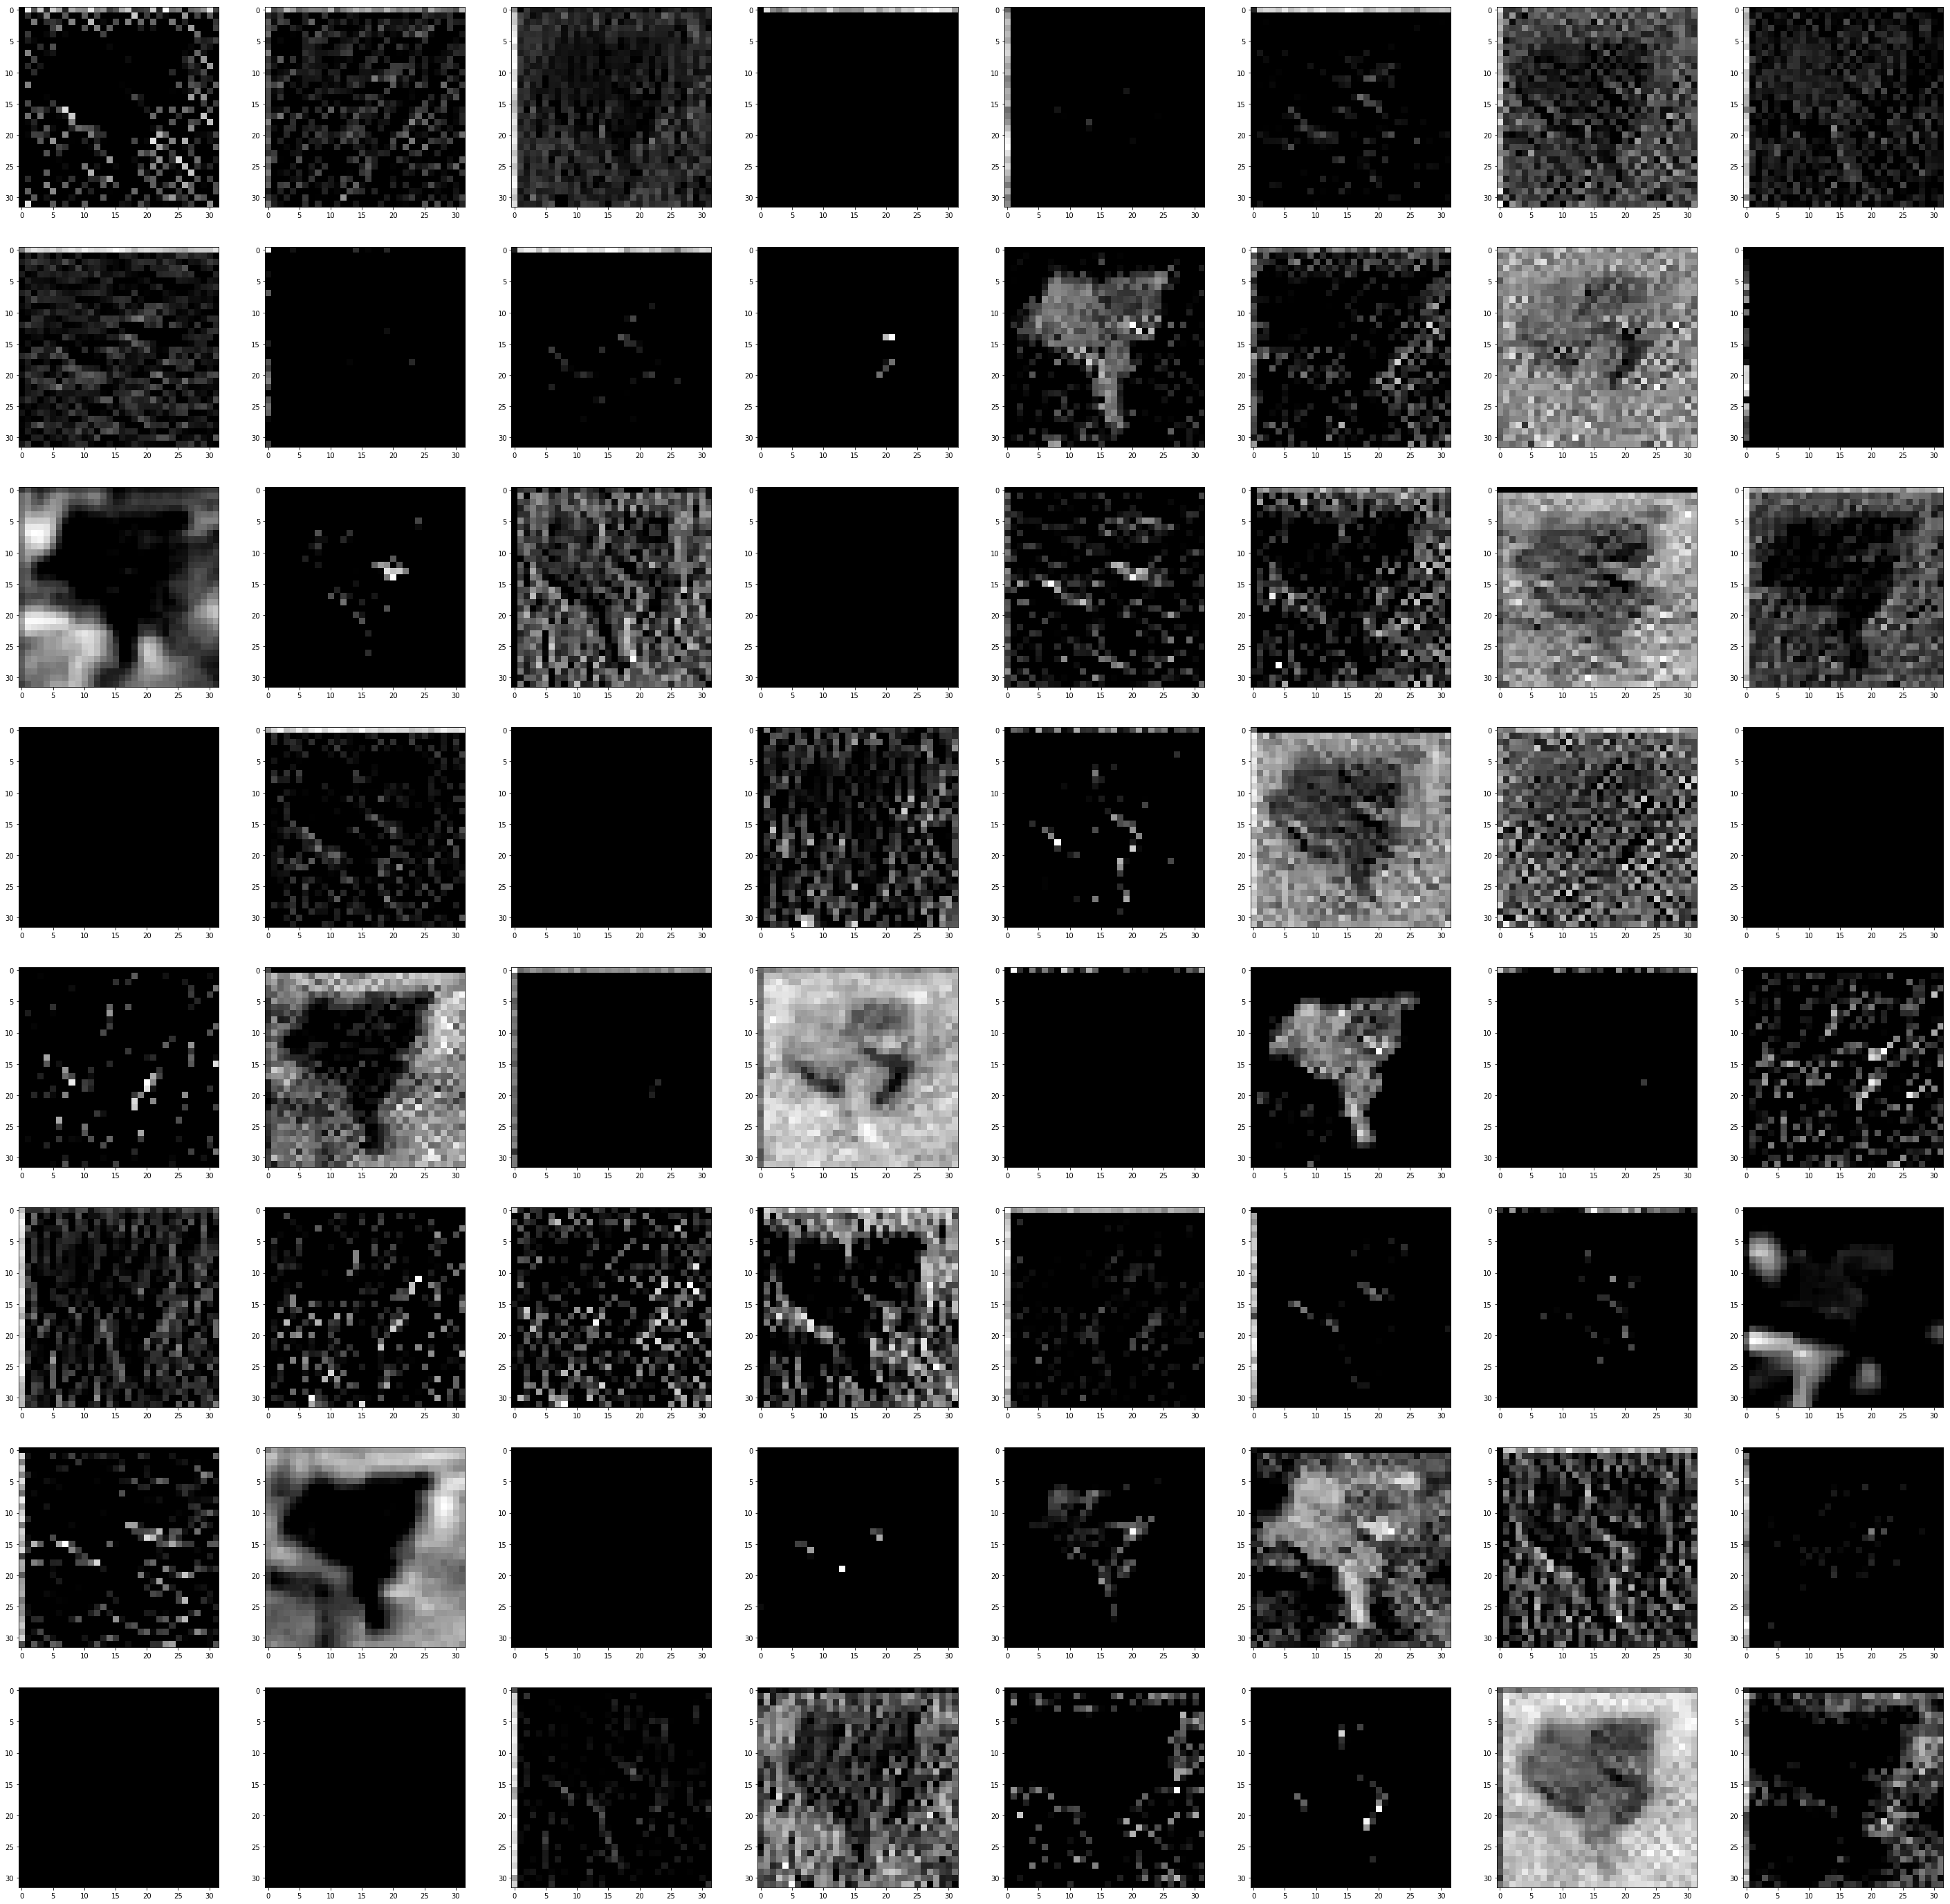

Cat


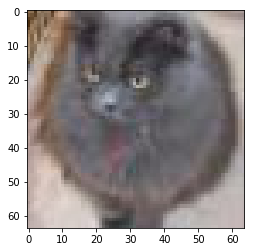

Output of convolution torch.Size([1, 64, 32, 32])


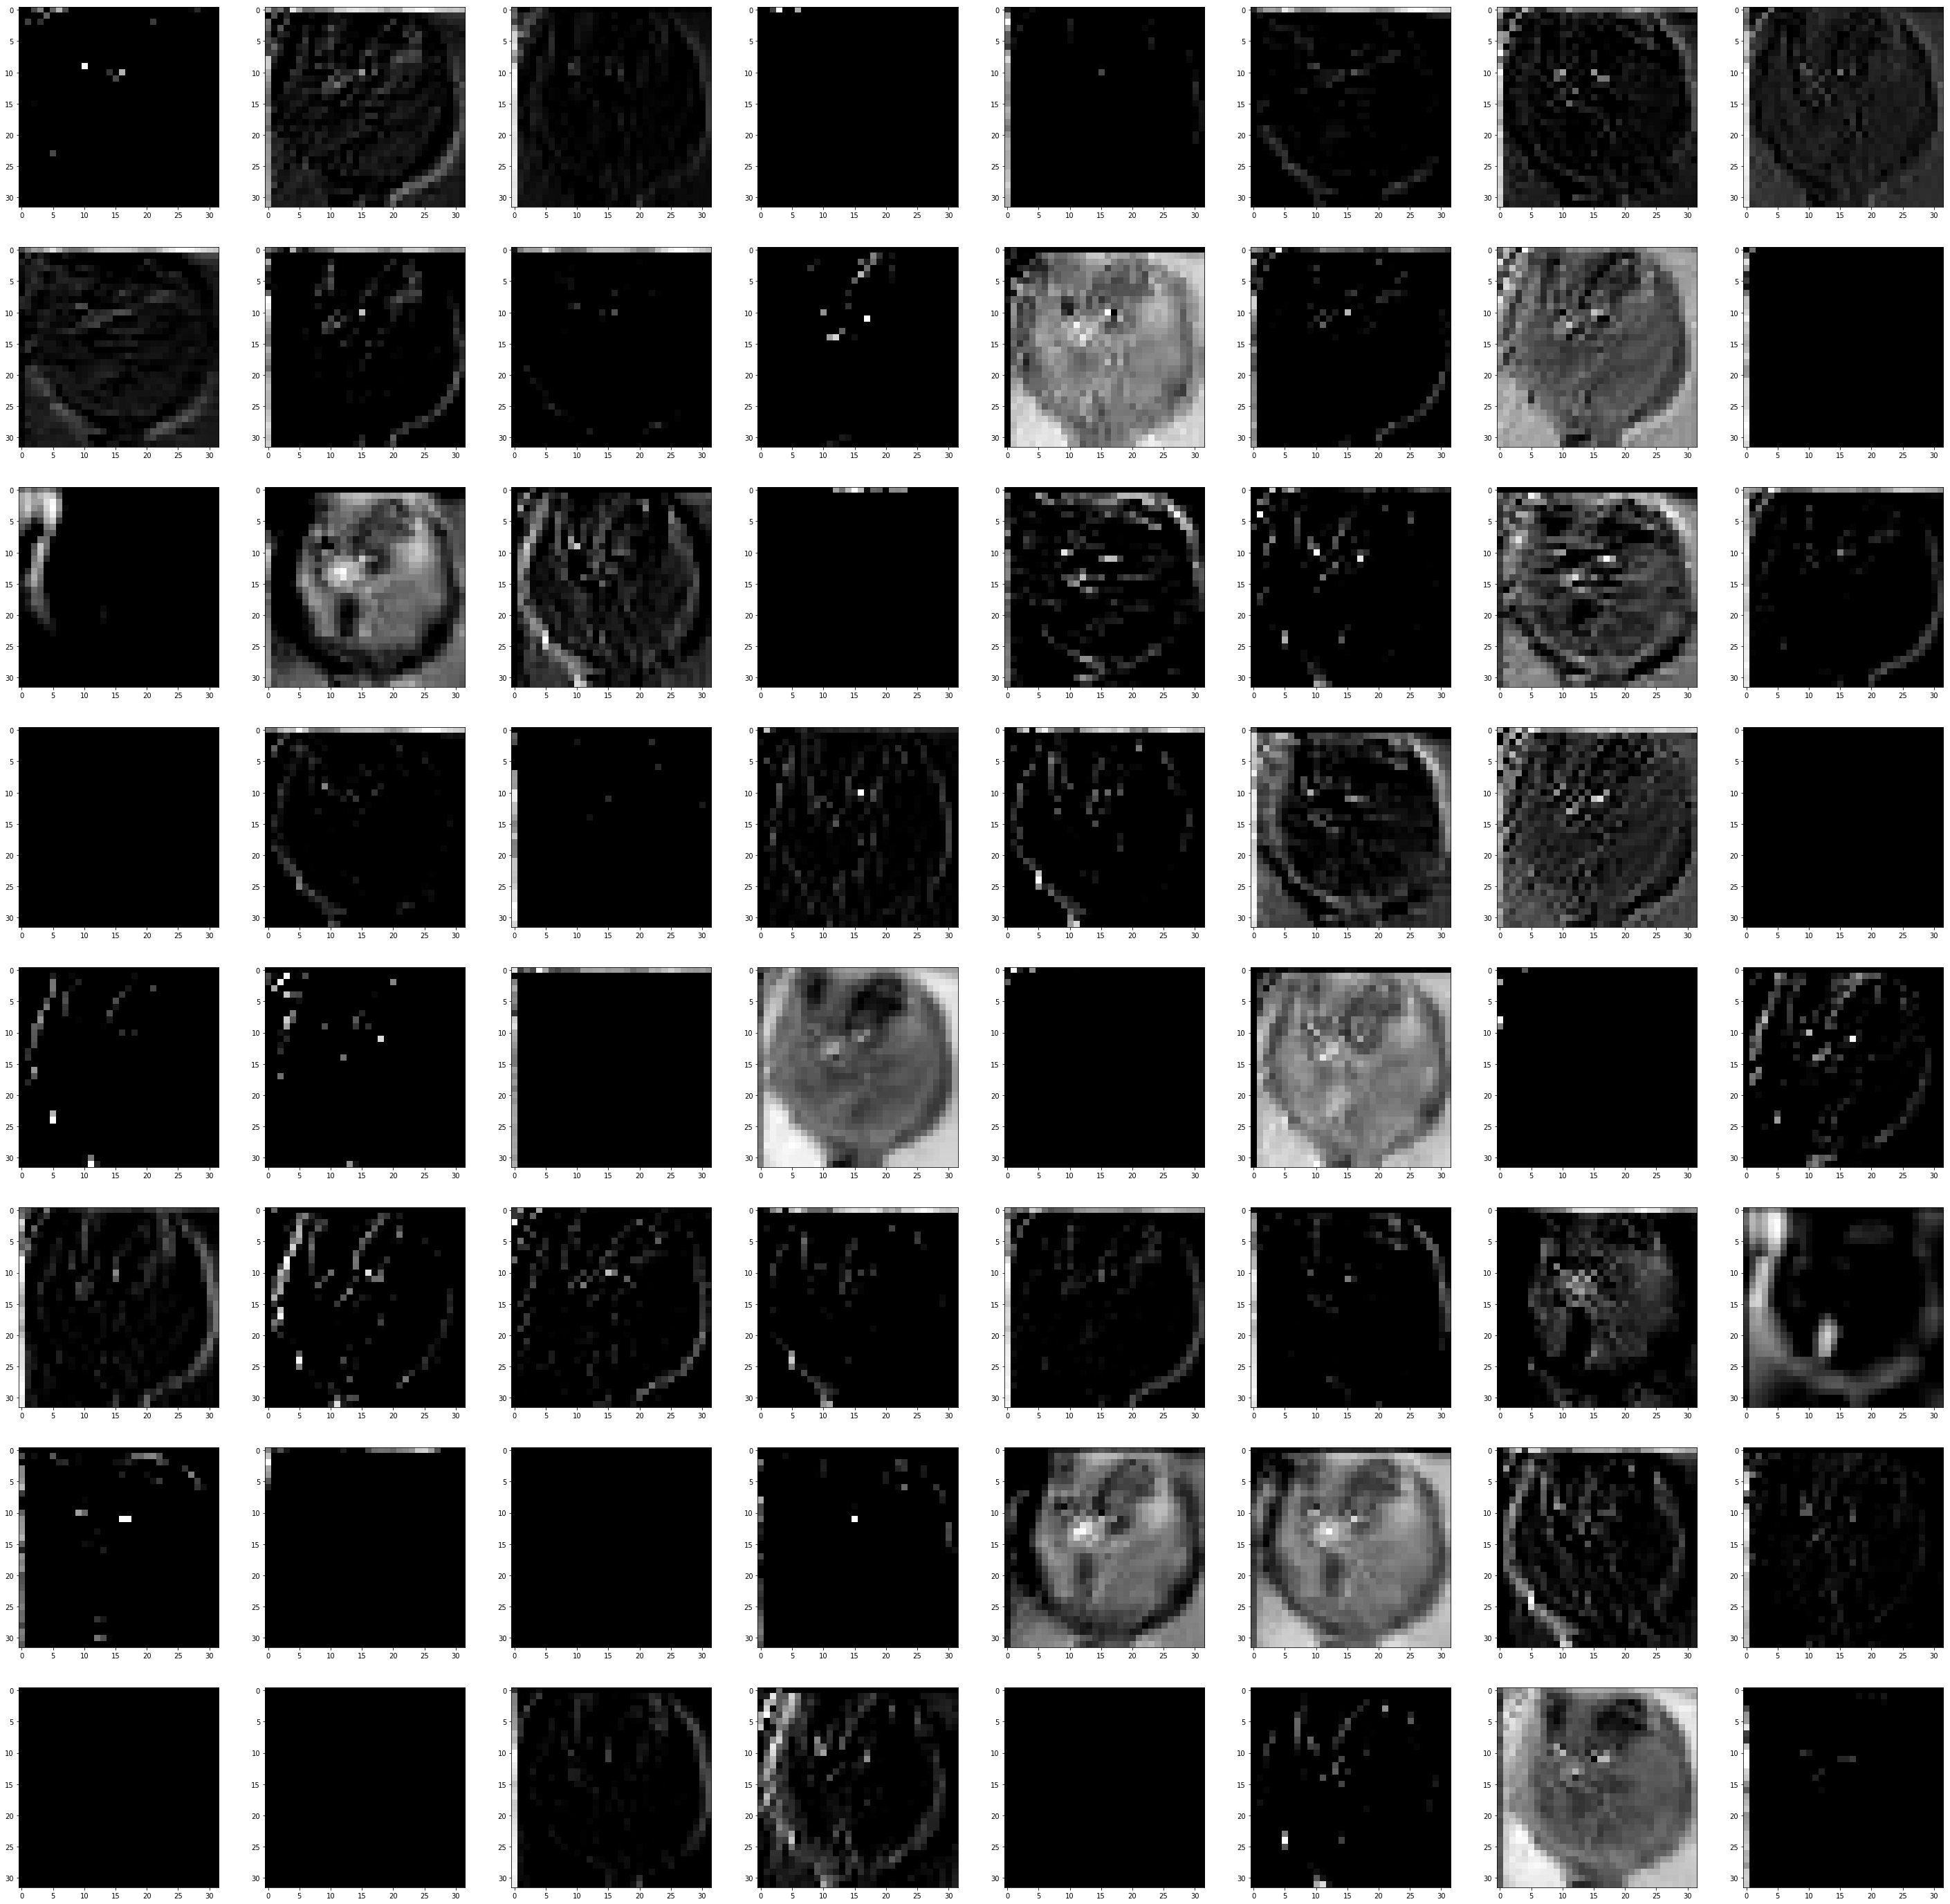

Cat


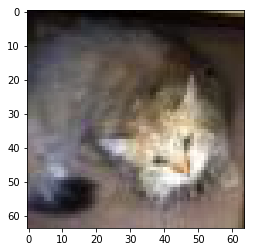

Output of convolution torch.Size([1, 64, 32, 32])


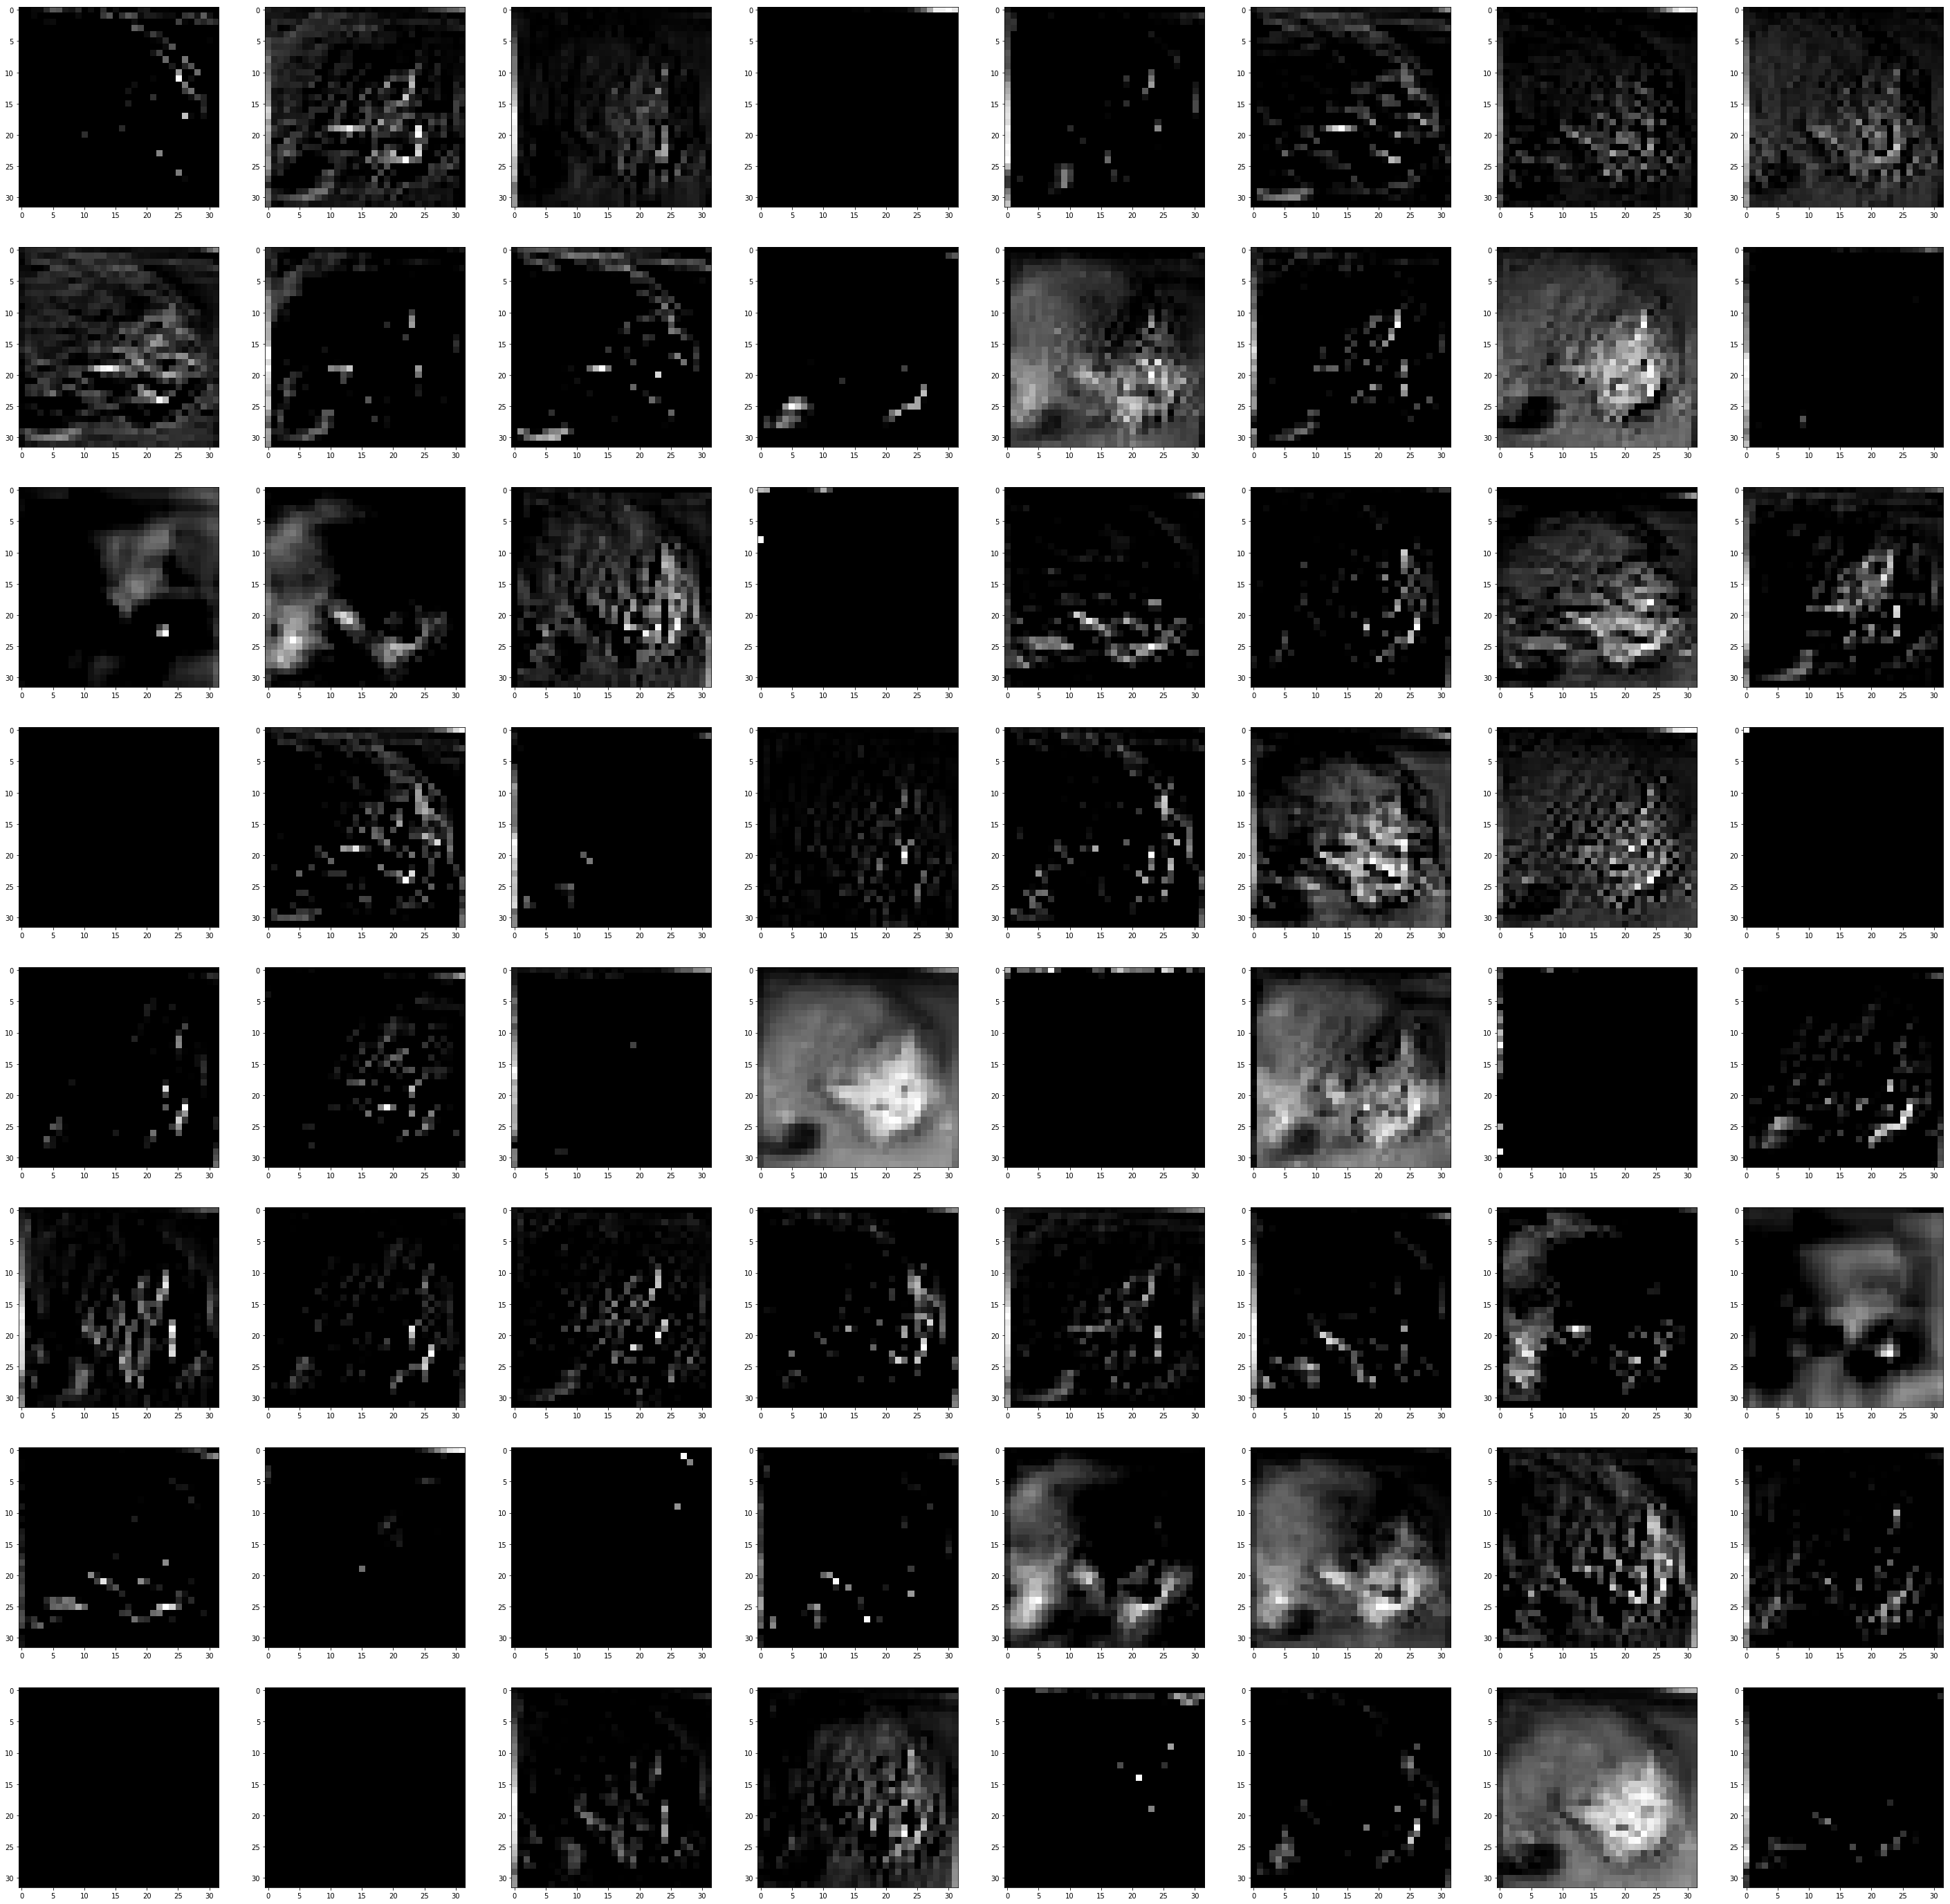

Cat


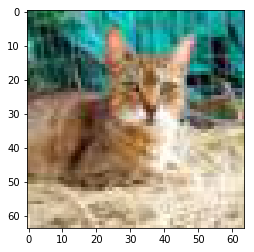

Output of convolution torch.Size([1, 64, 32, 32])


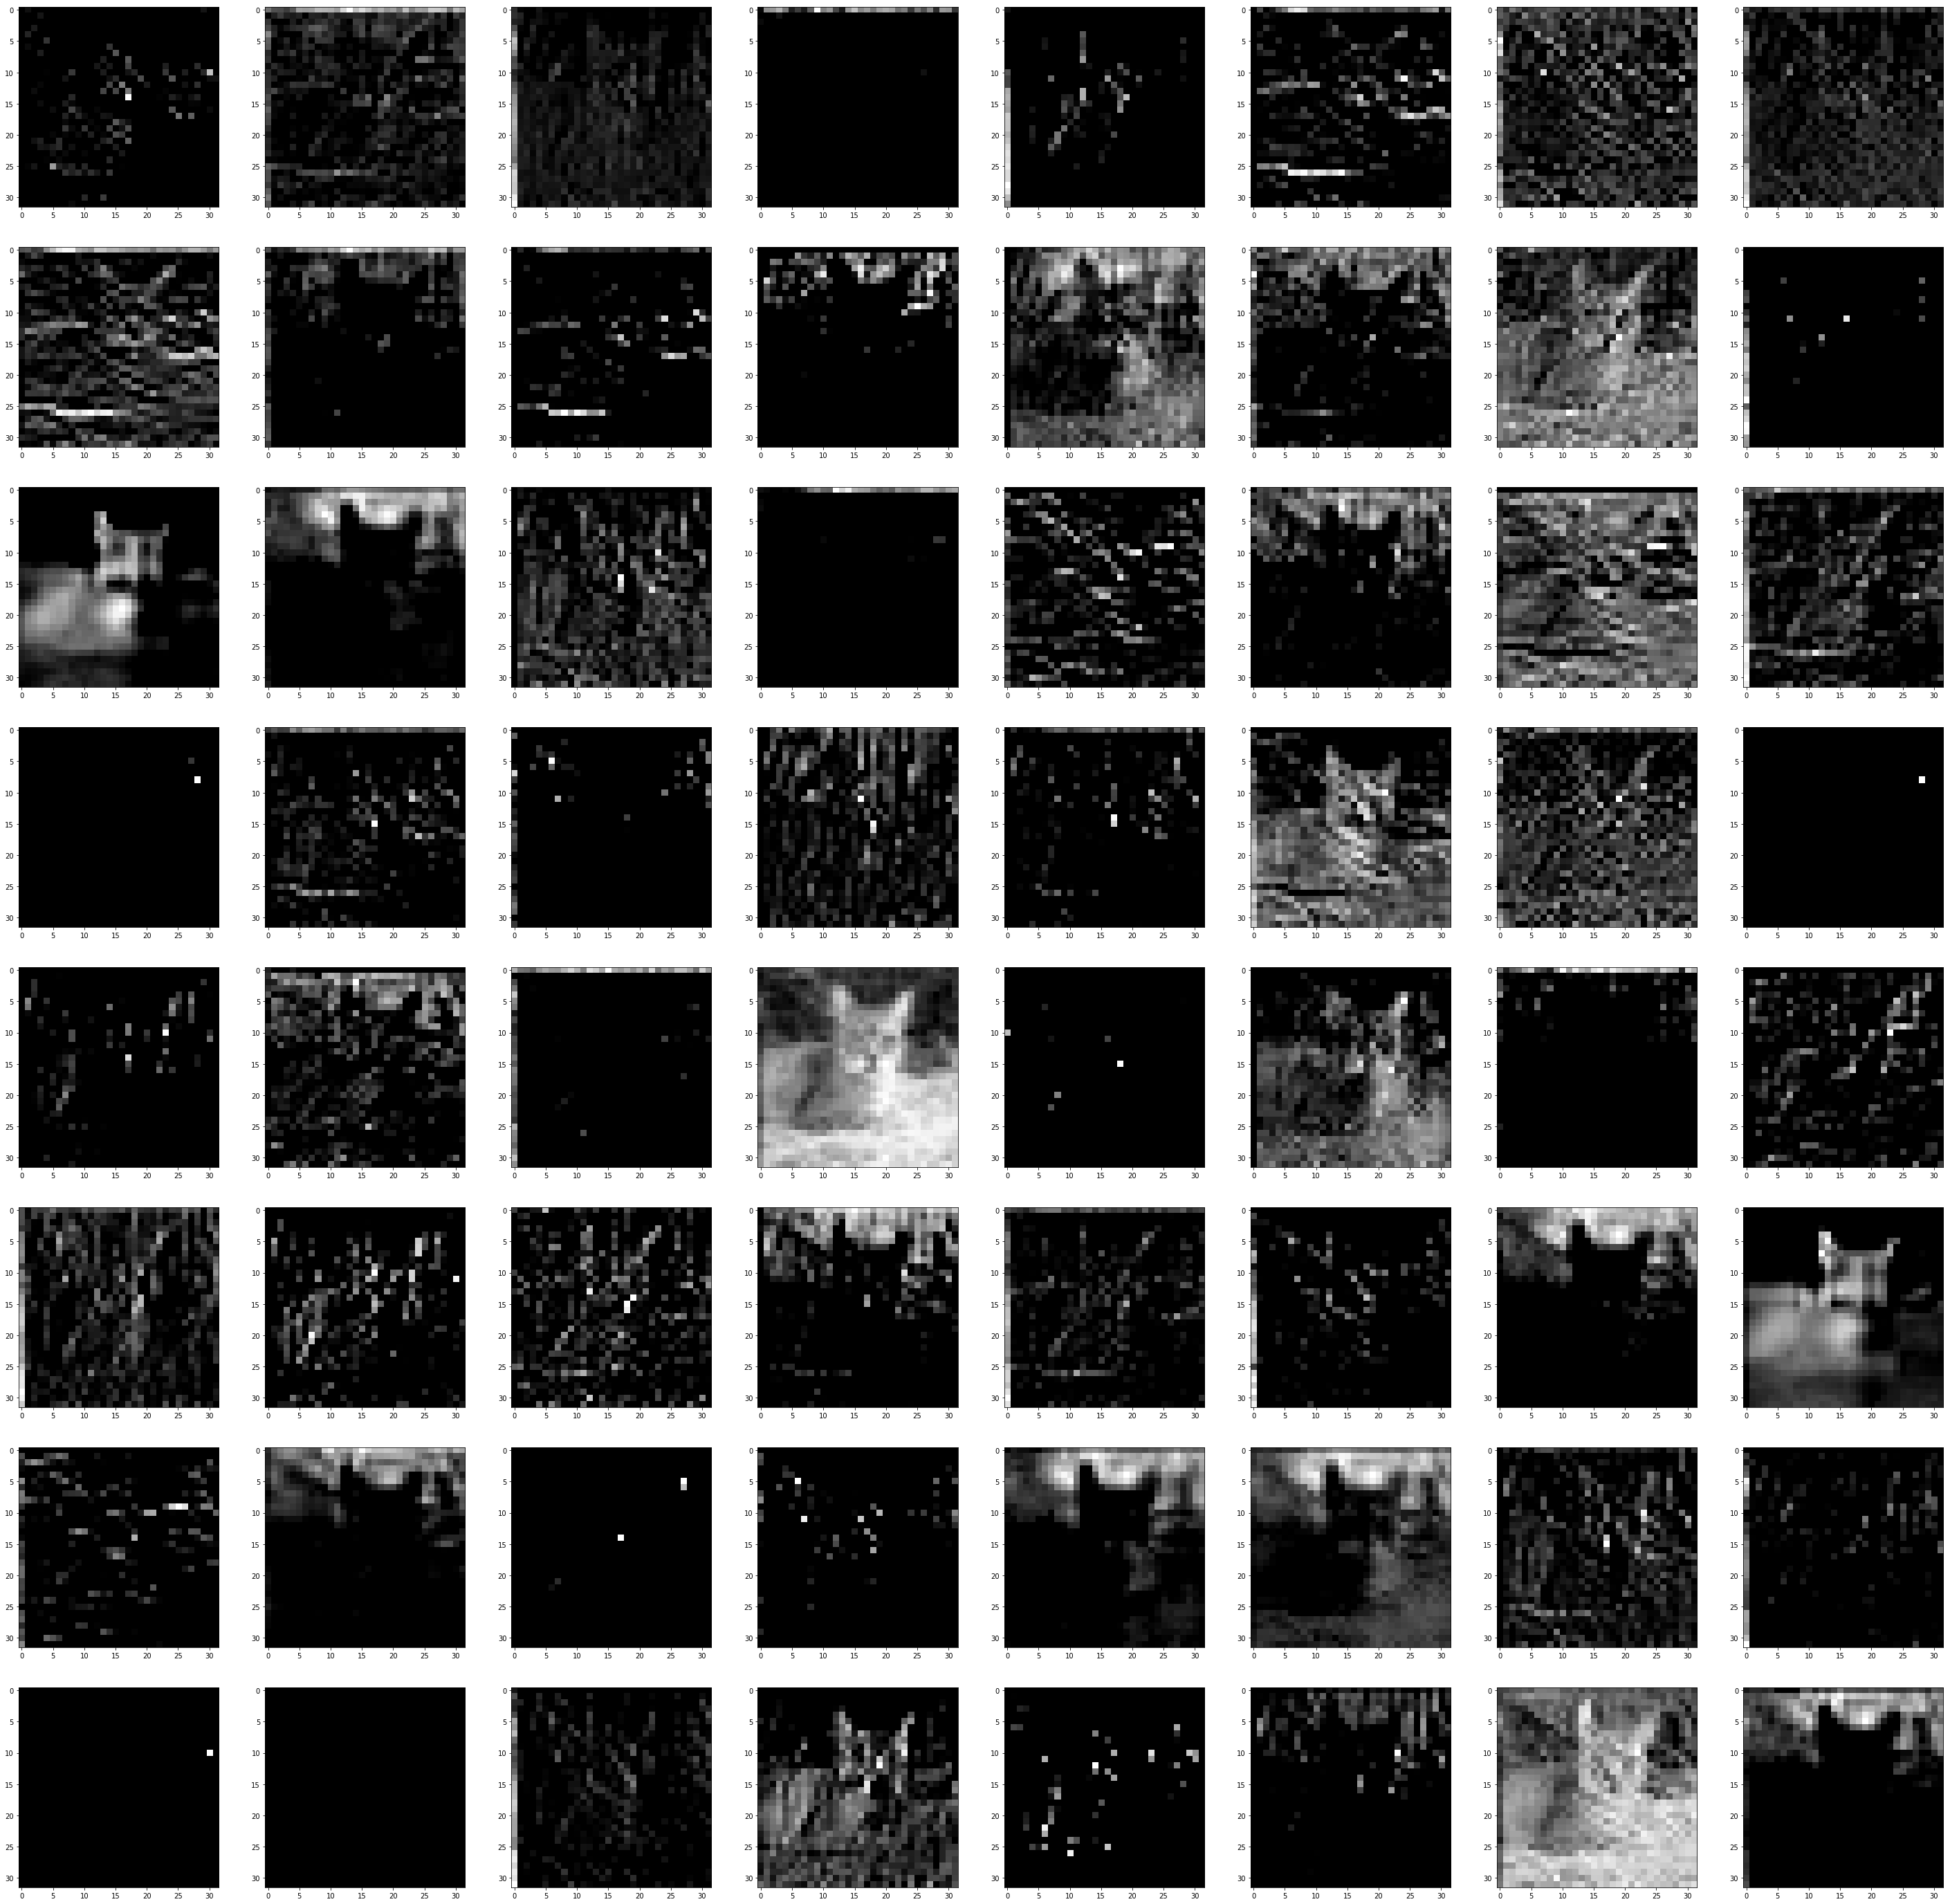

Cat


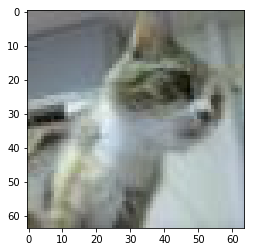

Output of convolution torch.Size([1, 64, 32, 32])


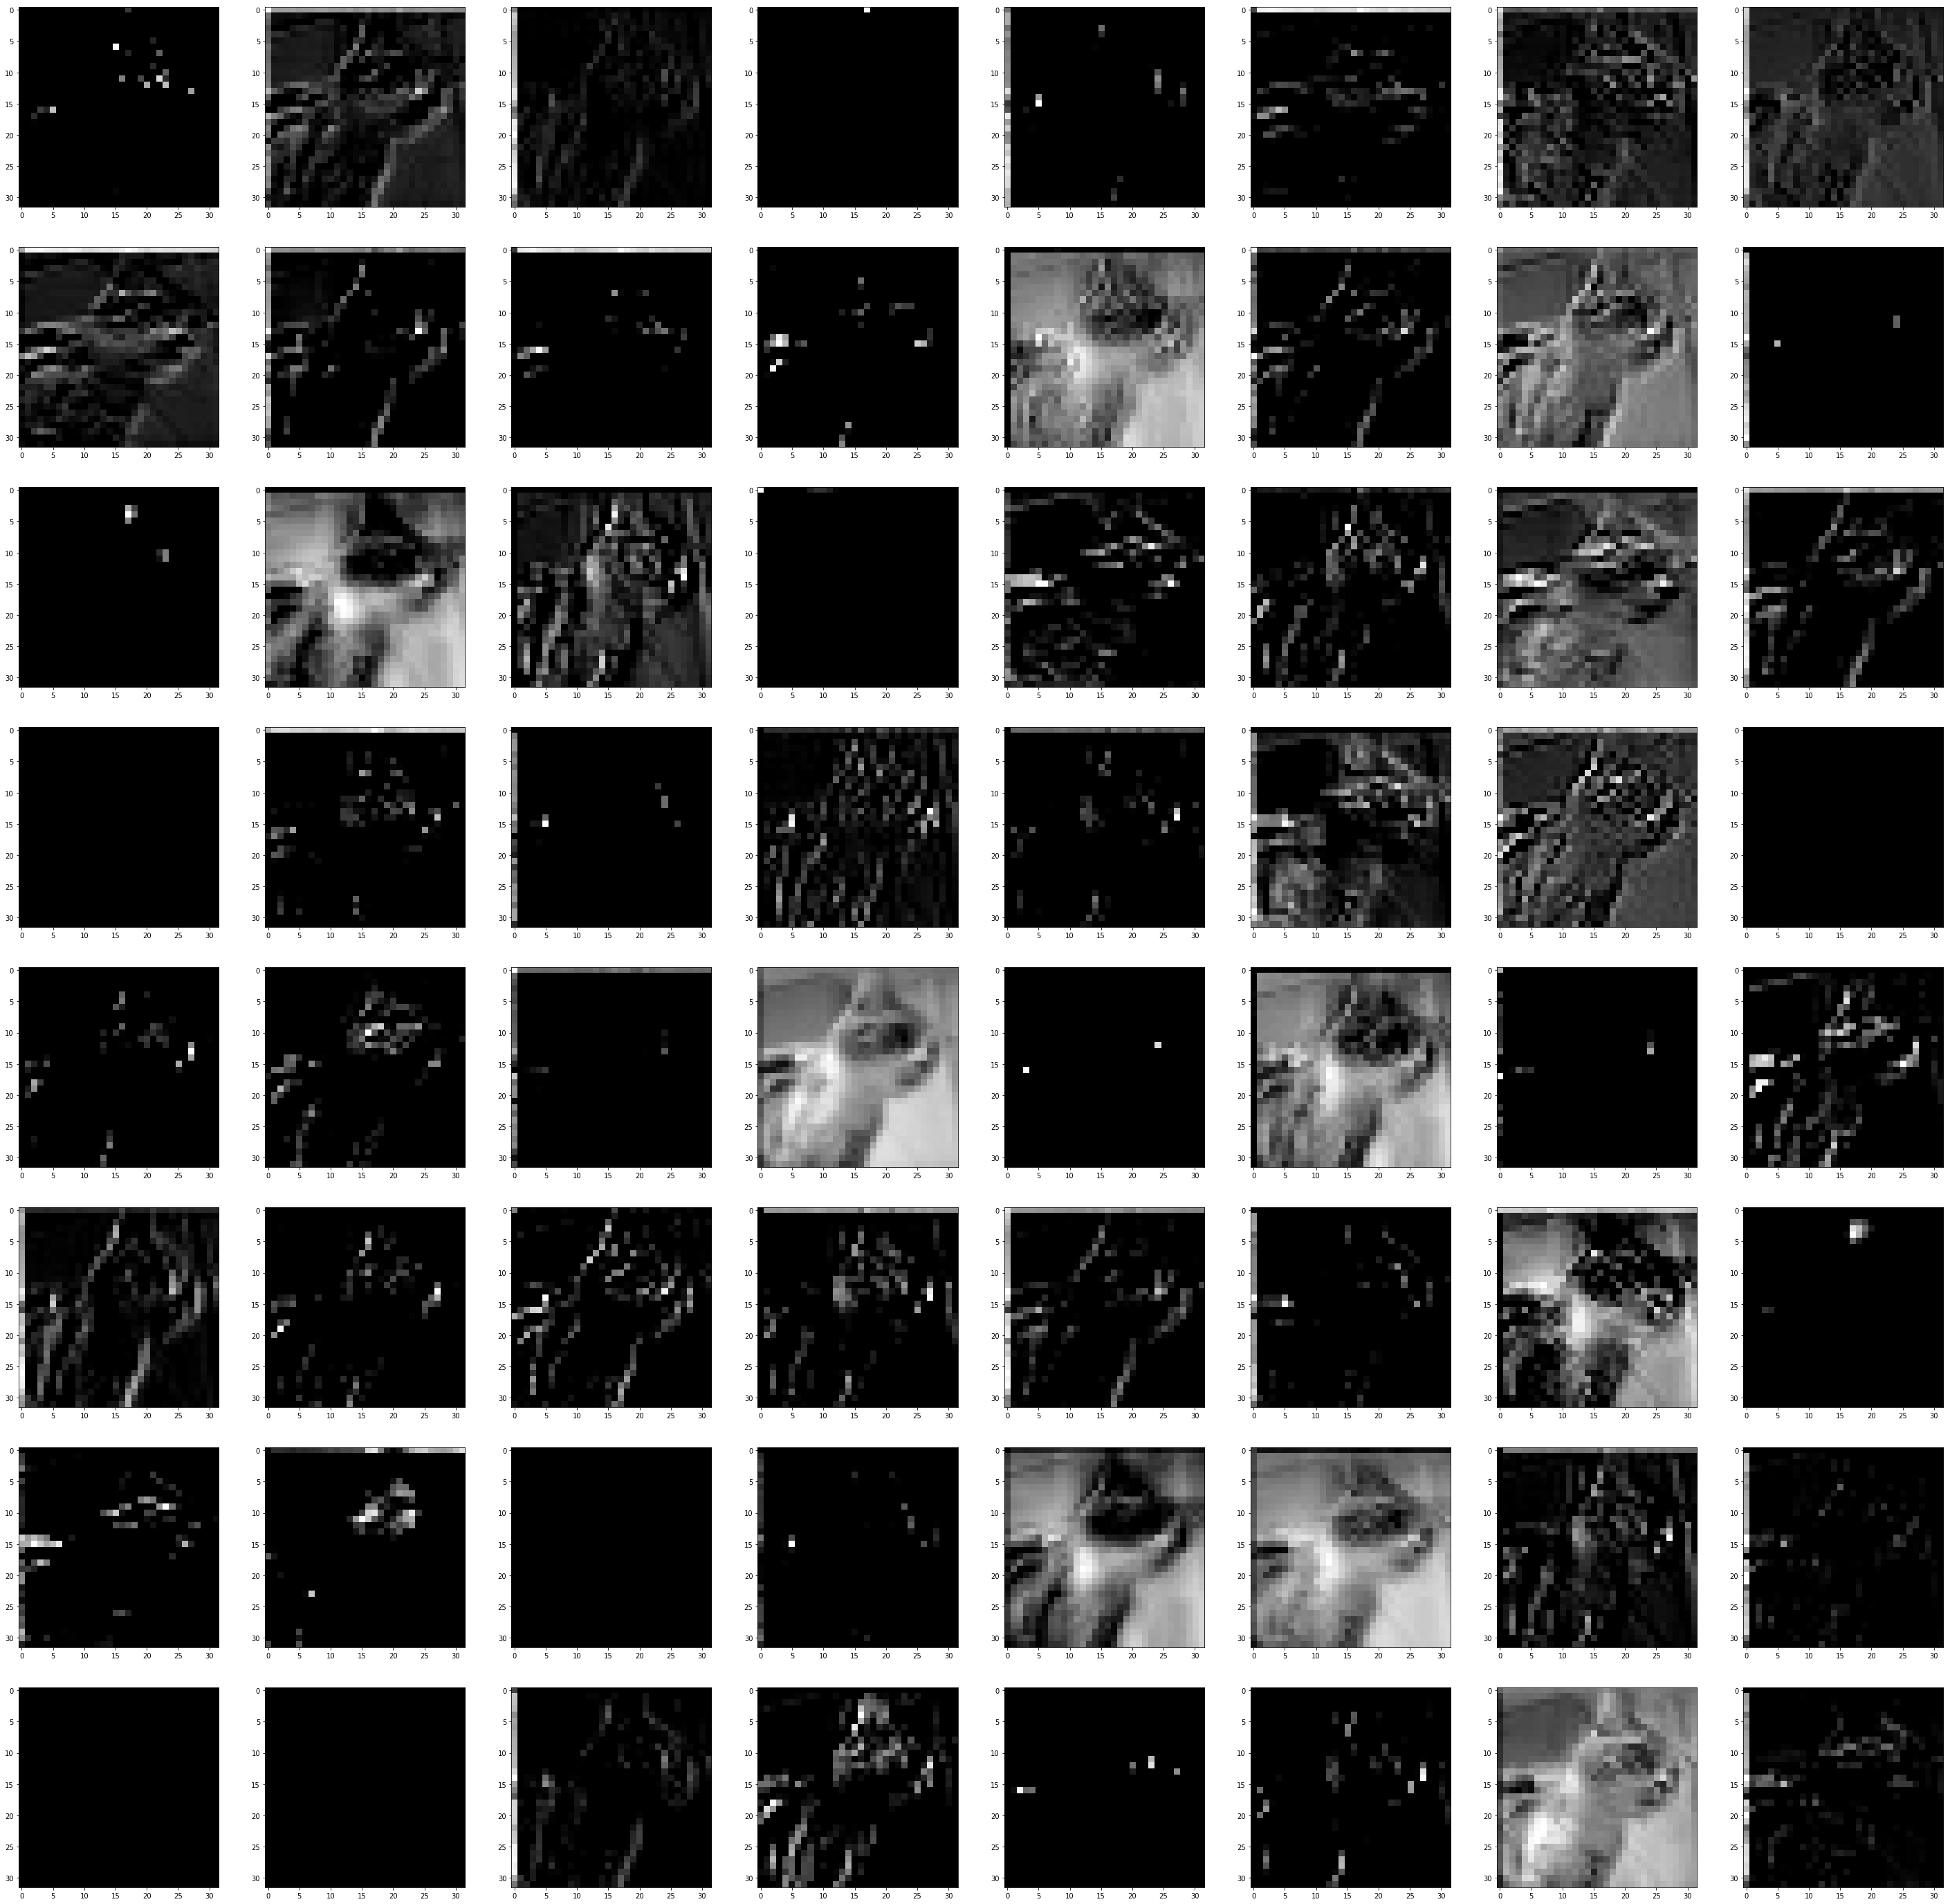

In [23]:
best_model.to("cuda")
# we cut out the last 11 layers of the model
new_classifier_without_fc = nn.Sequential(*list(best_model.children())[:2])

best_model.to("cpu")
# we get specefic weigts in model
weight = list(best_model.children())[-5:-4][0].conv2.weight.data.numpy()
best_model.to("cuda")
print("Weight values", weight.shape)
plt.imshow(weight[0,0,...])
plt.show()


for idx, (img, label)  in enumerate(test_loader_off):
    if idx > 6:
        break
        
    inputs = img.to(device)
    
    label = best_model(inputs)
    pred = sigmoid_(label).round()
    class_name_pred = full_dataset.classes[pred.int()]
    print(class_name_pred)
    
    output = new_classifier_without_fc(inputs)
    plt.imshow(np.transpose(img.to("cpu")[0].numpy(), (1, 2, 0)))
    plt.show()
    
    plt.figure(figsize=(50,50))
    print("Output of convolution", output.shape)
    for i in range(64):
        plt.subplot(8,8, i + 1)
        plt.imshow(output.detach().to("cpu").numpy()[0][i], cmap="gray")
    plt.show()
    
    
    


### Number of parameters

In [24]:
for parameter in best_model.parameters():
    print(parameter.shape)


torch.Size([64, 3, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([128, 64, 3, 3])
torch.Size([128, 128, 3, 3])
torch.Size([128, 64, 1, 1])
torch.Size([128, 128, 3, 3])
torch.Size([128, 128, 3, 3])
torch.Size([256, 128, 3, 3])
torch.Size([256, 256, 3, 3])
torch.Size([256, 128, 1, 1])
torch.Size([256, 256, 3, 3])
torch.Size([256, 256, 3, 3])
torch.Size([1, 256])
torch.Size([1])


## Analysis

### 1.


### 2.


### 3. 
When we look at our best model's convolution image results on a working example, we clearly see the model learned to put enphisis on the the cats fur patterns:
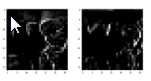
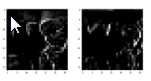
